In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import math
import empyrical as empy
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import warnings
warnings.filterwarnings("ignore")

In [3]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()


def other_metric(ret, true_up=None, true_ret=None):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric, true_up=true_up, true_ret=true_ret).T
    se = pd.Series(dtype='float64')
    pred_up = (ret!=0)*1
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()

    se['buy_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    
    if true_up is not None and true_ret is not None:
        idx_tmp = pred_up.index & true_up.index
        true_up_tmp = true_up.reindex(idx_tmp) * 1
        pred_up = pred_up.reindex(idx_tmp) * 1

        accu = accuracy_score(true_up_tmp, pred_up)
        prec = precision_score(true_up_tmp, pred_up)
        
        true_up_pct = true_ret.reindex(idx_tmp)
        true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
        
        mse = mean_squared_error(true_up_pct_scaled, pred_up)

        se['accu'] = accu
        se['prec'] = prec
        se['mse'] = mse
    
    return se


def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se

client_weight_agg = {'sharpe_ratio':5,'annual_return':5, 'max_drawdown':5}
client_weight_agg2 = {'sharpe_ratio':5,'annual_return':5, 'max_drawdown':5, 'avg_drawdown':5}
def calculation_score(df, client_weight=client_weight_agg, client_weight2=client_weight_agg2):
    df['Sharpe Score'] = df['sharpe_ratio'].apply(lambda x: x if x>0 else 0) * 100
    df['Return Score'] = df['annual_return'].apply(lambda x: 1+x/2) * 100
    df['Max-DD Score'] = df['max_drawdown'].apply(lambda x: 1+x) * 100
    df['Avg-DD Score'] = df['avg_drawdown'].apply(lambda x: 1+x) * 100

    df['Total Score'] = 0
    for score, weight in client_weight.items():
        df['Total Score'] += weight * df[score]

    df['Total Score2'] = 0
    for score, weight in client_weight2.items():
        df['Total Score2'] += weight * df[score]
    df.index.name = 'case'
    return df


def show_cum_ret(ret_df):
    fig, ax = plt.subplots(figsize=(20,15))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df.shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()


def print_all_result(ret_df, true_up, true_ret, proba_df=None, topn=10, strategy_list_sel=None, base_case=None):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    column_selected = ['total_return', 'annual_return', 'sharpe_ratio', 'max_drawdown', 'avg_drawdown', 'return/avgdd',]
    empy_metric_tmp = empy_metric(ret_df).sort_values('sharpe_ratio')
    # print(empy_metric_tmp.loc[['buy_and_hold']])
    if strategy_list_sel is None:
        empy_metric_tmp = empy_metric(ret_df).sort_values('sharpe_ratio')
        if isinstance(topn, int):
            strategy_list_sel = list(empy_metric_tmp.index)
            strategy_list_sel = strategy_list_sel[-topn:]
        else:
            strategy_list_sel = list(empy_metric_tmp.loc[topn:].index)
    else:
        if base_case is not None:
            usecols = list(set(strategy_list_sel + base_case))
        else:
            usecols = strategy_list_sel
        empy_metric_tmp = empy_metric(ret_df[usecols]).sort_values('sharpe_ratio')

    # if ('buy_and_hold') in strategy_list_sel:
    #     strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
    
    base_list = []
    if (base_case is not None) and (len(base_case) > 0):
        base_list = list(empy_metric_tmp.loc[base_case, :].index)
        for bc in base_list:
            if bc in strategy_list_sel:
                strategy_list_sel.remove(bc)

    strategy_list_sel = base_list + strategy_list_sel
    other_metric_tmp = other_metric(ret_df[strategy_list_sel], true_up, true_ret)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    plot_cum_return(ret_df[strategy_list_sel])
    
#     cvals  = [0, 0.5, 1]
#     colors = ["red", 'white', "lawngreen"]
#     cmap = LinearSegmentedColormap.from_list("", colors)
#     norm=plt.Normalize(min(cvals),max(cvals))
#     tuples = list(zip(map(norm,cvals), colors))
#     cmap = LinearSegmentedColormap.from_list("", tuples)
#     sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm
#     sm.set_array([])

    
    if proba_df is None:
        return strategy_list_sel

    alpha = 1
    dot_size = 20
    
    base_cumret = (1+ret_df[base_case]).cumprod().apply(math.log)
    base_cumret.name = 'buy_and_hold'
    
    for case in strategy_list_sel:
        if case not in proba_df.columns:
            continue
        print("====================================", case)
#         try:
        if True:
            df_temp = pd.concat([ret_df[case], proba_df[case]],1,keys=['return','pred prob']).dropna()

    #         df_temp['log return'] = (1+df_temp['return']).apply(math.log)
    #         df_temp['cumulative return'] = (1+df_temp['return']).cumprod()-1
            df_temp['log cumulative return'] = (1+df_temp['return']).cumprod().apply(math.log)

            z_ret = ret_df[case]/ret_df[case].std()
            z_prod = (proba_df[case]-0.5)/proba_df[case].std()
            df_temp['score'] = 3-abs(z_ret-z_prod)

            df_temp = df_temp.reset_index()
            df_temp['date'] = pd.to_datetime(df_temp['date'])
            
#             display(df_temp)
            
            plot_hue = 'pred prob'
        
            cvals  = [0,0.5,1]
            colors = ["red","white","lawngreen"]
            norm = plt.Normalize(min(cvals),max(cvals))
            tuples = list(zip(map(norm,cvals), colors))
            cmap_prob = LinearSegmentedColormap.from_list("", tuples)
            sm_prob = plt.cm.ScalarMappable(cmap=cmap_prob, norm=norm)
            sm_prob.set_array([])
            
            fig, ax = plt.subplots(figsize=(20,15))
            ax = sns.scatterplot(data=df_temp, x='date', y='log cumulative return', hue=plot_hue,
                                 #hue='score', alpha=0.5, palette=cmap, s=20)
                                 alpha=0.5, palette=cmap_prob, s=dot_size
#                                  cmap=cmap_prob
                                )
            base_cumret.plot(ax=ax)

            ax.set_xlim([df_temp['date'].iloc[0], df_temp['date'].iloc[-1]])
            ax.get_legend()#.remove()
#             ax.set_yscale("log")
            ax.figure.colorbar(sm_prob)
            ax.set_title("{} {}".format(case, plot_hue))
            plt.show()
            
#             fig, ax = plt.subplots(figsize=(12,10))
#             proba_df.loc[ret_df.index, case].plot(kind='bar', ax=ax, legend=False)
# #             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#             ax.set_title(case + ' proba')
#             plt.show()
#         except Exception as e:
#             print(e)
#             continue
    
    
    return strategy_list_sel

In [4]:
all_met_df_dict = {}
all_ret_df_dict = {}
start = '2013'

# Stage1: 
- without sliding cases

In [202]:
files = [
    './result/2022/cashON_signal/result/fix_threshold/ret_votes1.csv',
    # './result/2022/cashON_signal/result/fix_threshold/ret_votes2.csv',
]

all_ret_df = pd.DataFrame()
for f in files:
    ret = pd.read_csv(f, index_col=0)
    ret.index = pd.to_datetime(ret.index)
    all_ret_df = pd.concat([all_ret_df, ret], axis=1)
# all_ret_df

In [203]:
sort_by = 'sharpe_ratio'

In [204]:
all_met_df_b2012 = empy_metric(all_ret_df[:str(int(start)-1)])
all_met_df_b2012 = calculation_score(all_met_df_b2012)
all_met_df_b2012 = pd.concat([all_met_df_b2012, other_metric(all_ret_df[:str(int(start)-1)].dropna())], axis=1)

In [205]:
all_met_df_b2012 = all_met_df_b2012.loc[~all_met_df_b2012.index.duplicated(keep='first'), :]
sort_df_b2012 = all_met_df_b2012.sort_values(sort_by, ascending=False)
show_df_b2012 = sort_df_b2012.loc[sort_df_b2012.index.drop_duplicates(keep='first'), :]
show_df_b2012 = sort_df_b2012.loc[:'no_3vote', :]
display(sort_df_b2012.loc[['no_3vote'], :])
show_df_b2012.head(10)

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case,,,,,,,,,,,,,,,,
no_3vote,0.894476,0.136428,1.046531,0.130336,-0.206512,-0.038981,0.660631,3.499893,104.653088,106.821398,79.348844,96.101939,4.882236,4.687333,1.0,0.0


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case,,,,,,,,,,,,,,,,
corr_avg_abs__lb50__>0.58,1.141054,0.164603,1.339741,0.119048,-0.142190,-0.028555,1.157629,5.764494,133.974102,108.230170,85.780987,97.144530,6.810771,6.667998,0.851469,0.028617
corr_avg__lb15__out-of0.17&0.46,1.089643,0.158952,1.326839,0.116293,-0.128665,-0.030374,1.235394,5.233149,132.683908,107.947578,87.133530,96.962602,6.785630,6.633760,0.833201,0.062003
corr_avg__lb20__out-of0.18&0.45,1.074872,0.157307,1.321409,0.115638,-0.134725,-0.031656,1.167616,4.969242,132.140943,107.865352,86.527506,96.834386,6.719958,6.561677,0.812550,0.050874
corr_avg_abs__lb50__out-of0.37&0.58,1.070013,0.156764,1.292415,0.118091,-0.142190,-0.028773,1.102496,5.448363,129.241497,107.838204,85.780987,97.122731,6.534945,6.391081,0.838761,0.031797
corr_avg__lb50__out-of0.19&0.44,1.046191,0.154087,1.287521,0.116606,-0.131768,-0.027234,1.169386,5.657926,128.752057,107.704362,86.823241,97.276613,6.549201,6.413032,0.790310,0.038156
corr_avg__lb50__<0.19,1.057216,0.155329,1.284447,0.117835,-0.131768,-0.027959,1.178812,5.555613,128.444672,107.766459,86.823241,97.204104,6.540042,6.400247,0.819698,0.033386
vol_avg__lb50__out-of0.12&0.31,1.004625,0.149356,1.279305,0.113909,-0.128831,-0.040321,1.159314,3.704201,127.930494,107.467803,87.116855,95.967928,6.499148,6.297544,0.817315,0.012719
corr_avg__lb15__<0.17,1.054544,0.155029,1.264891,0.119618,-0.131768,-0.032387,1.176532,4.786828,126.489074,107.751436,86.823241,96.761348,6.440759,6.278827,0.874504,0.044515
vol_avg_pct__lb20__>0.04,1.037294,0.153081,1.248097,0.119902,-0.144639,-0.033741,1.058364,4.536963,124.809718,107.654054,85.536067,96.625913,6.282695,6.113990,0.984114,0.022258


In [206]:
all_met_df = empy_metric(all_ret_df[start:].dropna())
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df[start:].dropna())], axis=1)
all_met_df = all_met_df.loc[~all_met_df.index.duplicated(keep='first'), :]

In [207]:
all_met_df.to_csv('./result/2022/cashON_signal/result/fix_threshold/met_votes1(from{}).csv'.format(start))

In [208]:
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[:'no_3vote']
display(sort_df.loc[['no_3vote'], :])
display(all_met_df.loc[sort_df_b2012.index[:10], :])
display(show_df.head(5))

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case,,,,,,,,,,,,,,,,
no_3vote,1.129764,0.082225,0.65875,0.133536,-0.222995,-0.063756,0.368729,1.289684,65.874973,104.111245,77.70045,93.624417,2.589896,2.271117,1.0,0.0


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case,,,,,,,,,,,,,,,,
corr_avg_abs__lb50__>0.58,0.928469,0.071052,0.586355,0.131964,-0.222995,-0.073799,0.318627,0.962783,58.635529,103.552616,77.700450,92.620108,2.172061,1.803066,0.973870,0.007469
corr_avg__lb15__out-of0.17&0.46,0.409709,0.036543,0.365275,0.117068,-0.217686,-0.081862,0.167868,0.446395,36.527458,101.827130,78.231358,91.813836,0.920654,0.511346,0.782248,0.093776
corr_avg__lb20__out-of0.18&0.45,0.589895,0.049657,0.472830,0.117025,-0.202241,-0.072904,0.245531,0.681124,47.283048,102.482828,79.775856,92.709612,1.601228,1.236709,0.766072,0.065560
corr_avg_abs__lb50__out-of0.37&0.58,0.671059,0.055133,0.477966,0.130016,-0.230612,-0.076697,0.239074,0.718841,47.796570,102.756663,76.938783,92.330258,1.512434,1.128947,0.949813,0.015768
corr_avg__lb50__out-of0.19&0.44,0.556788,0.047350,0.438436,0.122764,-0.229337,-0.075085,0.206467,0.630628,43.843617,102.367520,77.066302,92.491550,1.282248,0.906825,0.831605,0.036100
corr_avg__lb50__<0.19,0.634595,0.052703,0.463838,0.128621,-0.229337,-0.078288,0.229806,0.673195,46.383768,102.635145,77.066302,92.171229,1.436018,1.044579,0.952717,0.011618
vol_avg__lb50__out-of0.12&0.31,0.600693,0.050399,0.505671,0.109025,-0.200017,-0.047332,0.251975,1.064811,50.567078,102.519971,79.998256,95.266819,1.780264,1.543605,0.697221,0.016598
corr_avg__lb15__<0.17,0.526219,0.045182,0.409960,0.127758,-0.229913,-0.080429,0.196516,0.561761,40.996011,102.259085,77.008677,91.957137,1.126143,0.724000,0.918706,0.033610
vol_avg_pct__lb20__>0.04,1.155330,0.083575,0.712973,0.123271,-0.216269,-0.059446,0.386443,1.405917,71.297328,104.178775,78.373149,94.055446,2.901401,2.604174,0.980091,0.027386


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case,,,,,,,,,,,,,,,,
vol_avg_pct__lb15__>0.06,1.853390,0.115822,0.955343,0.122616,-0.181172,-0.045222,0.639290,2.561162,95.534280,105.791082,81.882765,95.477769,4.449961,4.223849,0.982995,0.023237
corr_avg_pct__lb20__out-of-0.09&0.1,1.449860,0.098180,0.873367,0.114808,-0.164205,-0.044632,0.597910,2.199748,87.336705,104.908984,83.579520,95.536776,4.036710,3.813549,0.936956,0.087137
corr_std__lb15__<0.37,1.557661,0.103134,0.858573,0.123199,-0.175255,-0.045622,0.588476,2.260611,85.857255,105.156683,82.474454,95.437797,3.932254,3.704144,0.863542,0.053942
corr_avg_pct__lb20__>0.1,1.533743,0.102051,0.840641,0.124911,-0.143767,-0.042303,0.709834,2.412407,84.064143,105.102545,85.623281,95.769748,3.994626,3.783113,0.990046,0.017427
corr_avg_abs__lb15__<0.41,1.543627,0.102499,0.838859,0.125793,-0.155694,-0.049835,0.658338,2.056783,83.885887,105.124971,84.430572,95.016519,3.928320,3.679146,0.946080,0.037344


# Stage2:
use the sliding lookback period performance to choose one case for the following year

In [209]:
base_folder = './result/2022/cashON_signal/result/fix_threshold/FixThreshold_13ETFs_combine1Only/'

In [210]:
all_ret = {}
all_met = {}
for f in os.listdir(base_folder):
    try:
        case_folder = os.path.join(base_folder, f)
        for f2 in os.listdir(case_folder):
        
            case_type2 = [f] + f2.split('_')
            print(case_type2)

            ret = pd.read_csv(os.path.join(case_folder, f2, 'final_ret.csv'), index_col=0)
            names = ['case_metrics', 'case_combine']
            ret.columns = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in ret.columns], names=names)
            ret.index = pd.to_datetime(ret.index)
            all_ret[tuple(case_type2)] = ret
            met = pd.read_csv(os.path.join(case_folder, f2, 'final_metrics.csv'), index_col=0)
            names = ['case_metrics', 'case_combine']
            met.index = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in met.index], names=names)
            all_met[tuple(case_type2)] = met
    except:
        pass
    # break
all_ret_df = pd.concat(all_ret.values(), keys=all_ret.keys(), axis=1)
# all_met_df = pd.concat(all_met.values(), keys=all_met.keys())

['assetClass4groups', 'sliding1Y', 'CorrVol']
['assetClass4groups', 'sliding2Y', 'CorrVol']
['assetClass4groups', 'sliding3Y', 'CorrVol']
['assetClass4groups', 'sliding4Y', 'CorrVol']
['assetClass4groups', 'sliding5Y', 'CorrVol']
['assetClass4groups', 'sliding6Y', 'CorrVol']
['assetClass4groups', 'sliding7Y', 'CorrVol']
['assetClass4groups', 'sliding8Y', 'CorrVol']
['cluster13groups', 'sliding1Y', 'CorrVol']
['cluster13groups', 'sliding2Y', 'CorrVol']
['cluster13groups', 'sliding3Y', 'CorrVol']
['cluster13groups', 'sliding4Y', 'CorrVol']
['cluster13groups', 'sliding5Y', 'CorrVol']
['cluster13groups', 'sliding6Y', 'CorrVol']
['cluster13groups', 'sliding7Y', 'CorrVol']
['cluster13groups', 'sliding8Y', 'CorrVol']
['cluster4groups', 'sliding1Y', 'CorrVol']
['cluster4groups', 'sliding2Y', 'CorrVol']
['cluster4groups', 'sliding3Y', 'CorrVol']
['cluster4groups', 'sliding4Y', 'CorrVol']
['cluster4groups', 'sliding5Y', 'CorrVol']
['cluster4groups', 'sliding6Y', 'CorrVol']
['cluster4groups', 'sl

In [211]:
# 13ETFs	v1	sliding1Y	2thresholds	combine2	no_3vote
idx_names = ['correlate_assets', 'sliding_year', 'case_pool', 'case_metrics', 'case_combine']
all_ret_df.columns.names = idx_names
# all_met_df.index.names = idx_names

In [212]:
all_met_df = empy_metric(all_ret_df[start:])
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df.dropna())], axis=1)
# all_met_df

In [213]:
all_met_df.to_csv(os.path.join(base_folder, 'met(from{}).csv'.format(start)))

In [214]:
base_case_name = 'no_3vote'
base_case_ret = all_ret_df.loc[:, all_ret_df.columns.get_level_values('case_combine') == base_case_name].iloc[:, [0]]
base_case_ret.columns = pd.MultiIndex.from_tuples([("", "", "", "", base_case_name)], names=idx_names)
# display(base_case_ret)
base_case_met = all_met_df.loc[all_met_df.index.get_level_values('case_combine') == base_case_name, :].iloc[[0], :]
base_case_met.index = pd.MultiIndex.from_tuples([("", "", "", "", base_case_name)], names=idx_names)
base_case_met

,,,,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
correlate_assets,sliding_year,case_pool,case_metrics,case_combine,,,,,,,,,,,,,,,,
,,,,no_3vote,1.129764,0.081452,0.65875,0.133536,-0.222995,-0.063756,0.365263,1.27756,65.874973,104.072595,77.70045,93.624417,2.586031,2.267252,1.0,0.0


In [215]:
sort_by = 'sharpe_ratio'
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
show_df = pd.concat([base_case_met, show_df])
show_df.head(20)

total_return  \
correlate_assets  sliding_year case_pool case_metrics case_combine                 
                                                      no_3vote          1.129764   
cluster13groups   sliding8Y    CorrVol   Total Score  combine1          1.251946   
                                         Total Score2 combine1          1.228716   
                                         sharpe_ratio combine1          1.182973   
cluster4groups    sliding8Y    CorrVol                no_3vote          1.041942   
assetClass4groups sliding8Y    CorrVol                no_3vote          1.041942   
cluster13groups   sliding8Y    CorrVol                no_3vote          1.041942   
                  sliding4Y    CorrVol   Total Score2 combine1          1.530433   
cluster4groups    sliding8Y    CorrVol   sharpe_ratio combine1          0.942131   
                                         Total Score2 combine1          0.958313   
                                         Total Score  combine1          0.958313   
                  sliding3Y    CorrVol   Total Score  combine1          1.511278   
cluster13groups   sliding6Y    CorrVol   Total Score  combine1          1.176278   
                                         sharpe_ratio combine1          1.176278   
                                         Total Score2 combine1          1.176278   
assetClass4groups sliding7Y    CorrVol   Total Score  combine1          0.935429   
                                         Total Score2 combine1          0.935429   
cluster13groups   sliding5Y    CorrVol   sharpe_ratio combine1          1.241243   
cluster4groups    sliding3Y    CorrVol   Total Score2 combine1          1.287803   
assetClass4groups sliding3Y    CorrVol   sharpe_ratio combine1          1.200599   

                                                                    annual_return  \
correlate_assets  sliding_year case_pool case_metrics case_combine                  
                                                      no_3vote           0.081452   
cluster13groups   sliding8Y    CorrVol   Total Score  combine1           0.087718   
                                         Total Score2 combine1           0.086551   
                                         sharpe_ratio combine1           0.084219   
cluster4groups    sliding8Y    CorrVol                no_3vote           0.076745   
assetClass4groups sliding8Y    CorrVol                no_3vote           0.076745   
cluster13groups   sliding8Y    CorrVol                no_3vote           0.076745   
                  sliding4Y    CorrVol   Total Score2 combine1           0.100934   
cluster4groups    sliding8Y    CorrVol   sharpe_ratio combine1           0.071171   
                                         Total Score2 combine1           0.072092   
                                         Total Score  combine1           0.072092   
                  sliding3Y    CorrVol   Total Score  combine1           0.100068   
cluster13groups   sliding6Y    CorrVol   Total Score  combine1           0.083875   
                                         sharpe_ratio combine1           0.083875   
                                         Total Score2 combine1           0.083875   
assetClass4groups sliding7Y    CorrVol   Total Score  combine1           0.070787   
                                         Total Score2 combine1           0.070787   
cluster13groups   sliding5Y    CorrVol   sharpe_ratio combine1           0.087182   
cluster4groups    sliding3Y    CorrVol   Total Score2 combine1           0.089500   
assetClass4groups sliding3Y    CorrVol   sharpe_ratio combine1           0.085123   

                                                                    sharpe_ratio  \
correlate_assets  sliding_year case_pool case_metrics case_combine                 
                                                      no_3vote          0.658750   
cluster13groups   sliding8Y    CorrVol   Total Score  combine1          1.055558   
            

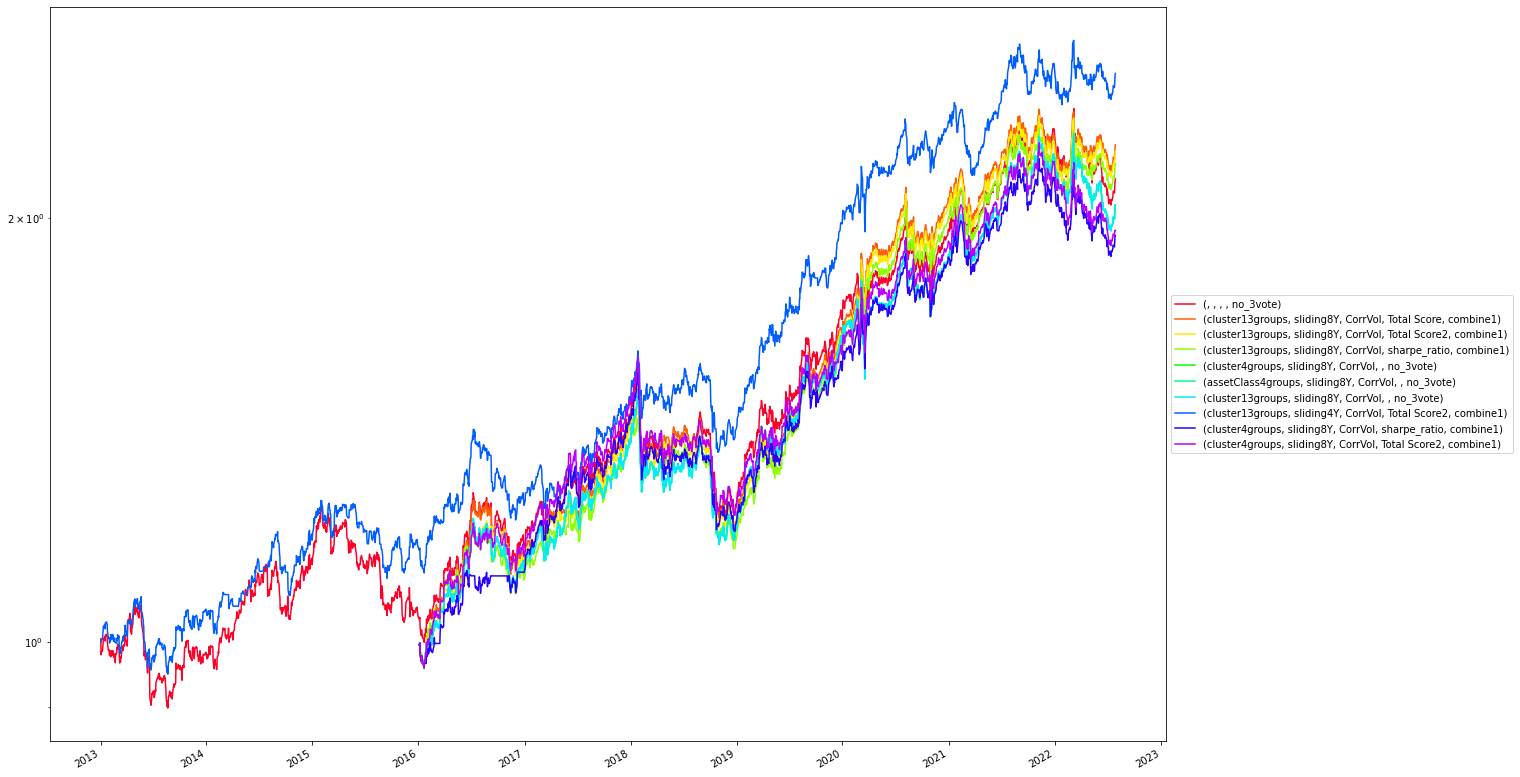

In [216]:
show_ret = pd.concat([base_case_ret, all_ret_df[show_df.index[1:10]]], axis=1)
show_cum_ret(show_ret[start:])

In [217]:
groupby_items = ['correlate_assets', 'sliding_year', 'case_pool', 'case_metrics', 'case_combine']

all_met_df_count = all_met_df.loc[all_met_df.index.get_level_values('case_combine') != base_case_name, :]
show_df_count = show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
base_met_single_index = base_case_met.copy()
base_met_single_index.index = [base_case_name]


for gb in groupby_items:
    print("================================================== ", gb)

    ser1 = show_df_count.groupby(gb).count().mean(axis=1)
    ser2 = all_met_df_count.groupby(gb).count().mean(axis=1)
    ser3 = ser1 / ser2
    df = pd.concat([ser1.to_frame(), ser2.to_frame(), ser3.to_frame()], axis=1)
    df.columns = ['better', 'total', 'pct']
    display(df)

    perf = all_met_df_count.groupby(gb).mean()
    perf = pd.concat([base_met_single_index, perf])
    display("average: ", perf)

    perf_std = all_met_df_count.groupby(gb).max()
    display("max: ", perf_std)

    perf_std = all_met_df_count.groupby(gb).min()
    display("min: ", perf_std)

    perf_std = all_met_df_count.groupby(gb).std()
    display("std: ", perf_std)

==================================================  correlate_assets


,better,total,pct
correlate_assets,,,
assetClass4groups,15.25,21.75,0.701149
cluster13groups,12.00,21.75,0.551724
cluster4groups,10.25,21.75,0.471264


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.081452,0.658750,0.133536,-0.222995,-0.063756,0.365263,1.277560,65.874973,104.072595,77.700450,93.624417,2.586031,2.267252,1.000000,0.000000
assetClass4groups,0.922079,0.069556,0.673176,0.120095,-0.171435,-0.048169,0.412254,1.544577,67.317644,103.477780,82.856539,95.183068,2.856487,2.627016,0.917699,0.055975
cluster13groups,0.959029,0.071275,0.704533,0.119411,-0.196799,-0.055312,0.372024,1.247884,70.453276,103.563768,80.320118,94.468822,2.895047,2.084720,0.915559,0.040306
cluster4groups,0.896979,0.067885,0.650315,0.123569,-0.211548,-0.060319,0.327565,1.203652,65.031454,103.394271,78.845204,93.968103,2.533260,2.127591,0.939451,0.032144


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
correlate_assets,,,,,,,,,,,,,,,,
assetClass4groups,1.200599,0.085123,0.760577,0.125082,-0.148309,-0.043803,0.549067,1.943305,76.057655,104.256150,85.169077,95.619679,3.382553,3.163537,0.967372,0.070133
cluster13groups,1.530433,0.100934,1.055558,0.125069,-0.152461,-0.044126,0.662032,2.287415,105.555768,105.046694,84.753924,95.587425,4.758647,3.865790,0.987915,0.057437
cluster4groups,1.511278,0.100068,0.866393,0.127838,-0.163004,-0.048082,0.571070,2.081193,86.639275,105.003389,83.699586,95.191807,3.777835,3.537425,0.989728,0.067715


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
correlate_assets,,,,,,,,,,,,,,,,
assetClass4groups,0.513895,0.043887,0.517618,0.114658,-0.214115,-0.052821,0.204970,1.234341,51.761779,102.194360,78.588464,94.717885,1.736948,2.314708,0.811480,0.036276
cluster13groups,0.467421,0.040521,0.403081,0.109102,-0.229798,-0.067543,0.213406,0.599937,40.308094,102.026072,77.020191,93.245713,1.268612,0.930898,0.669486,0.021765
cluster4groups,0.539668,0.045714,0.451179,0.114555,-0.227289,-0.069847,0.223744,0.697097,45.117881,102.285700,77.271111,93.015297,1.502228,1.174340,0.760725,0.018138


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
correlate_assets,,,,,,,,,,,,,,,,
assetClass4groups,0.184961,0.011068,0.060268,0.002975,0.017295,0.003676,0.087469,0.250639,6.026825,0.553382,1.729488,0.367550,0.369217,0.313533,0.059632,0.009968
cluster13groups,0.260542,0.014943,0.175252,0.004517,0.026744,0.008492,0.111457,0.416334,17.525166,0.747154,2.674448,0.849176,0.991875,0.724068,0.101242,0.010497
cluster4groups,0.230208,0.013150,0.121145,0.004088,0.021889,0.008078,0.092353,0.411251,12.114481,0.657497,2.188917,0.807758,0.676953,0.720674,0.078366,0.013164


==================================================  sliding_year


,better,total,pct
sliding_year,,,
sliding1Y,3.00,9.00,0.333333
sliding2Y,1.00,9.00,0.111111
sliding3Y,6.00,9.00,0.666667
sliding4Y,3.00,9.00,0.333333
sliding5Y,2.00,9.00,0.222222
sliding6Y,6.75,6.75,1.000000
sliding7Y,6.75,6.75,1.000000
sliding8Y,9.00,6.75,1.333333


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.081452,0.658750,0.133536,-0.222995,-0.063756,0.365263,1.277560,65.874973,104.072595,77.700450,93.624417,2.586031,2.267252,1.000000,0.000000
sliding1Y,0.753508,0.059222,0.559558,0.114927,-0.174298,-0.051679,0.352937,1.204877,55.955762,102.961094,82.570208,94.832132,2.222408,1.964015,0.788251,0.042456
sliding2Y,0.933464,0.070591,0.641000,0.118240,-0.190636,-0.052127,0.377578,1.355599,64.100010,103.529550,80.936368,94.787326,2.604774,2.344140,0.872038,0.055152
sliding3Y,1.086115,0.078267,0.686450,0.120976,-0.189993,-0.052821,0.430435,1.545827,68.644981,103.913360,81.000706,94.717873,2.873620,2.609514,0.942263,0.035671
sliding4Y,0.990729,0.073043,0.647575,0.120855,-0.185476,-0.055374,0.408207,1.385246,64.757520,103.652133,81.452417,94.462556,2.675710,2.398838,0.972743,0.041986
sliding5Y,0.913017,0.069222,0.616627,0.121773,-0.208375,-0.060999,0.338669,1.168638,61.662690,103.461080,79.162475,93.900101,2.387366,2.082371,0.965290,0.051659
sliding6Y,1.020375,0.075345,0.725296,0.123648,-0.196949,NaN,0.393714,NaN,72.529556,103.767253,80.305119,NaN,3.018459,NaN,0.961195,0.047158
sliding7Y,0.783287,0.061405,0.673136,0.124344,-0.200354,NaN,0.315240,NaN,67.313625,103.070235,79.964596,NaN,2.670935,NaN,0.961934,0.035873
sliding8Y,0.927739,0.069483,0.858422,0.123439,-0.200003,NaN,0.348135,NaN,85.842188,103.474149,79.999739,NaN,3.639511,NaN,0.930178,0.032514


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,1.046074,0.076971,0.680005,0.120807,-0.148309,-0.044010,0.518989,1.748951,68.000515,103.848540,85.169077,95.599031,3.043334,2.823285,0.934139,0.064087
sliding2Y,1.092866,0.079496,0.707235,0.120478,-0.161419,-0.050314,0.487693,1.579994,70.723541,103.974802,83.858055,94.968586,3.118637,2.867066,0.931722,0.067715
sliding3Y,1.511278,0.100068,0.830728,0.125352,-0.155032,-0.043803,0.571070,2.081193,83.072761,105.003389,84.496779,95.619679,3.777835,3.537425,0.987311,0.054414
sliding4Y,1.530433,0.100934,0.868811,0.125229,-0.152461,-0.044126,0.662032,2.287415,86.881062,105.046694,84.753924,95.587425,4.086419,3.865790,0.986103,0.065296
sliding5Y,1.241243,0.087182,0.760519,0.125450,-0.164205,-0.046774,0.464804,1.631728,76.051899,104.359091,83.579520,95.322567,3.126902,2.836601,0.982477,0.070133
sliding6Y,1.176278,0.083875,0.814220,0.126806,-0.166016,NaN,0.505219,NaN,81.422019,104.193730,83.398358,NaN,3.660392,NaN,0.984290,0.061669
sliding7Y,0.935429,0.070787,0.760577,0.126703,-0.165440,NaN,0.427872,NaN,76.057655,103.539361,83.456000,NaN,3.329619,NaN,0.987915,0.048368
sliding8Y,1.251946,0.087718,1.055558,0.127838,-0.181172,NaN,0.457948,NaN,105.555768,104.385920,81.882765,NaN,4.758647,NaN,0.989728,0.043531


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,0.539668,0.045714,0.451179,0.109102,-0.196447,-0.065578,0.232704,0.697097,45.117881,102.285700,80.355273,93.442236,1.502228,1.174340,0.669486,0.027811
sliding2Y,0.837287,0.065031,0.612015,0.114658,-0.229798,-0.052685,0.315929,1.234341,61.201471,103.251562,77.020191,94.731500,2.451232,2.192076,0.811480,0.044135
sliding3Y,0.656895,0.053692,0.510753,0.116696,-0.229530,-0.065740,0.233921,0.816732,51.075275,102.684597,77.047010,93.426001,1.674574,1.345874,0.848943,0.021765
sliding4Y,0.467421,0.040521,0.403081,0.116252,-0.227289,-0.067543,0.213406,0.599937,40.308094,102.026072,77.271111,93.245713,1.268612,0.930898,0.957100,0.021765
sliding5Y,0.753653,0.059904,0.531511,0.119614,-0.227289,-0.069847,0.263560,0.857651,53.151055,102.995218,77.271111,93.015297,1.820630,1.471395,0.949849,0.029021
sliding6Y,0.847918,0.065668,0.632650,0.120408,-0.227289,NaN,0.288918,NaN,63.264981,103.283394,77.271111,NaN,2.355144,NaN,0.944411,0.029021
sliding7Y,0.513895,0.043887,0.517618,0.119756,-0.227289,NaN,0.204970,NaN,51.761779,102.194360,77.271111,NaN,1.736948,NaN,0.837462,0.021765
sliding8Y,0.609086,0.050501,0.667271,0.119225,-0.227289,NaN,0.278748,NaN,66.727096,102.525068,77.271111,NaN,2.683000,NaN,0.842900,0.018138


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,0.221931,0.013502,0.093805,0.004993,0.021042,0.009201,0.126364,0.435671,9.380452,0.675120,2.104234,0.920150,0.639047,0.676287,0.116271,0.016562
sliding2Y,0.084391,0.004817,0.029650,0.002718,0.031480,0.000791,0.056399,0.112124,2.965032,0.240875,3.147970,0.079116,0.205325,0.207862,0.052075,0.009012
sliding3Y,0.283874,0.015773,0.111806,0.003238,0.030858,0.008324,0.134195,0.474111,11.180571,0.788655,3.085812,0.832356,0.774790,0.814085,0.053814,0.013546
sliding4Y,0.276292,0.015729,0.120167,0.003274,0.033170,0.010362,0.130749,0.474475,12.016725,0.786445,3.316955,1.036247,0.743801,0.782669,0.012363,0.017194
sliding5Y,0.153942,0.008668,0.074498,0.002678,0.025218,0.008666,0.070725,0.287019,7.449800,0.433403,2.521805,0.866553,0.477297,0.514240,0.013026,0.016369
sliding6Y,0.140615,0.007798,0.078327,0.002585,0.026535,NaN,0.093301,NaN,7.832734,0.389904,2.653547,NaN,0.562726,NaN,0.016736,0.013411
sliding7Y,0.154272,0.009777,0.093286,0.002055,0.025021,NaN,0.084579,NaN,9.328615,0.488870,2.502067,NaN,0.616736,NaN,0.047200,0.009971
sliding8Y,0.266350,0.015566,0.162990,0.003528,0.020952,NaN,0.078089,NaN,16.299008,0.778294,2.095195,NaN,0.872121,NaN,0.066982,0.009297


==================================================  case_pool


,better,total,pct
case_pool,,,
CorrVol,37.5,65.25,0.574713


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.081452,0.658750,0.133536,-0.222995,-0.063756,0.365263,1.277560,65.874973,104.072595,77.700450,93.624417,2.586031,2.267252,1.000000,0.000000
CorrVol,0.926029,0.069572,0.676008,0.121025,-0.193260,-0.054600,0.370614,1.332038,67.600792,103.478607,80.673954,94.539998,2.761598,2.279776,0.924236,0.042809


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_pool,,,,,,,,,,,,,,,,
CorrVol,1.530433,0.100934,1.055558,0.127838,-0.148309,-0.043803,0.662032,2.287415,105.555768,105.046694,85.169077,95.619679,4.758647,3.86579,0.989728,0.070133


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_pool,,,,,,,,,,,,,,,,
CorrVol,0.467421,0.040521,0.403081,0.109102,-0.229798,-0.069847,0.20497,0.599937,40.308094,102.026072,77.020191,93.015297,1.268612,0.930898,0.669486,0.018138


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_pool,,,,,,,,,,,,,,,,
CorrVol,0.225607,0.013037,0.127989,0.004272,0.027607,0.008569,0.102366,0.390367,12.798865,0.651872,2.760653,0.856875,0.733486,0.652165,0.081116,0.014939


==================================================  case_metrics


,better,total,pct
case_metrics,,,
,6.75,NaN,NaN
Total Score,9.25,21.75,0.425287
Total Score2,9.25,21.75,0.425287
sharpe_ratio,12.25,21.75,0.563218


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.081452,0.658750,0.133536,-0.222995,-0.063756,0.365263,1.277560,65.874973,104.072595,77.700450,93.624417,2.586031,2.267252,1.000000,0.000000
Total Score,0.929523,0.069839,0.678756,0.121070,-0.192670,-0.054538,0.373270,1.329098,67.875597,103.491930,80.733045,94.546162,2.779625,2.270663,0.925428,0.042624
Total Score2,0.932967,0.069952,0.679851,0.120999,-0.192670,-0.054708,0.374788,1.334839,67.985088,103.497591,80.733045,94.529162,2.785666,2.288975,0.924950,0.043128
sharpe_ratio,0.915597,0.068926,0.669417,0.121006,-0.194442,-0.054553,0.363786,1.332176,66.941690,103.446299,80.555770,94.544669,2.719503,2.279689,0.922331,0.042674


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,1.511278,0.100068,1.055558,0.127838,-0.148309,-0.044010,0.571070,2.081193,105.555768,105.003389,85.169077,95.599031,4.758647,3.537425,0.989728,0.065296
Total Score2,1.530433,0.100934,1.053499,0.127838,-0.148309,-0.044010,0.662032,2.287415,105.349871,105.046694,85.169077,95.599031,4.742515,3.865790,0.989728,0.065296
sharpe_ratio,1.241243,0.087182,1.019205,0.126806,-0.148309,-0.043803,0.549067,1.943305,101.920476,104.359091,85.169077,95.619679,4.559388,3.163537,0.987915,0.070133


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,0.602891,0.050082,0.487257,0.109377,-0.229798,-0.069847,0.232538,0.797100,48.725707,102.504085,77.020191,93.015297,1.674574,1.345874,0.670091,0.018138
Total Score2,0.593386,0.049435,0.487257,0.109102,-0.229798,-0.069847,0.223744,0.797100,48.725707,102.471754,77.020191,93.015297,1.674574,1.345874,0.669486,0.018138
sharpe_ratio,0.467421,0.040521,0.403081,0.109377,-0.229798,-0.069536,0.204970,0.599937,40.308094,102.026072,77.020191,93.046396,1.268612,0.930898,0.670091,0.021765


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,0.220634,0.012501,0.127260,0.004345,0.027998,0.008853,0.100695,0.390763,12.725962,0.625065,2.799771,0.885288,0.733351,0.633708,0.082613,0.015322
Total Score2,0.235590,0.013346,0.132672,0.004363,0.027998,0.008763,0.109866,0.425640,13.267193,0.667298,2.799771,0.876346,0.771513,0.706459,0.082381,0.014912
sharpe_ratio,0.229703,0.013771,0.129237,0.004291,0.027977,0.008693,0.100316,0.380849,12.923721,0.688564,2.797683,0.869304,0.724540,0.660203,0.081820,0.015220


==================================================  case_combine


,better,total,pct
case_combine,,,
combine1,30.75,65.25,0.471264
no_3vote,6.75,NaN,NaN


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.081452,0.658750,0.133536,-0.222995,-0.063756,0.365263,1.277560,65.874973,104.072595,77.700450,93.624417,2.586031,2.267252,1.000000,0.000000
combine1,0.926029,0.069572,0.676008,0.121025,-0.193260,-0.054600,0.370614,1.332038,67.600792,103.478607,80.673954,94.539998,2.761598,2.279776,0.924236,0.042809


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_combine,,,,,,,,,,,,,,,,
combine1,1.530433,0.100934,1.055558,0.127838,-0.148309,-0.043803,0.662032,2.287415,105.555768,105.046694,85.169077,95.619679,4.758647,3.86579,0.989728,0.070133


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_combine,,,,,,,,,,,,,,,,
combine1,0.467421,0.040521,0.403081,0.109102,-0.229798,-0.069847,0.20497,0.599937,40.308094,102.026072,77.020191,93.015297,1.268612,0.930898,0.669486,0.018138


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_combine,,,,,,,,,,,,,,,,
combine1,0.225607,0.013037,0.127989,0.004272,0.027607,0.008569,0.102366,0.390367,12.798865,0.651872,2.760653,0.856875,0.733486,0.652165,0.081116,0.014939


# Stage3:

Sliding lookback window to choose 
- the threshold
- the condition case

In [254]:
base_folder = './result/2022/cashON_signal/result/yearly_threshold/fixAssetB2012_combine1Only/'
filter_case = ['13ETFs']


In [255]:
all_ret = {}
all_met = {}
for f in os.listdir(base_folder):
    try:
        case_folder = os.path.join(base_folder, f)
        for f2 in os.listdir(case_folder):
            case_type2 = [f] + f2.split('_')
            print(case_type2)

            ret = pd.read_csv(os.path.join(case_folder, f2, 'final_ret.csv'), index_col=0)
            names = ['case_metrics', 'case_combine']
            ret.columns = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in ret.columns], names=names)
            ret.index = pd.to_datetime(ret.index)
            all_ret[tuple(case_type2)] = ret
            met = pd.read_csv(os.path.join(case_folder, f2, 'final_metrics.csv'), index_col=0)
            names = ['case_metrics', 'case_combine']
            met.index = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in met.index], names=names)
            all_met[tuple(case_type2)] = met
    except:
        pass
    # break
all_ret_df = pd.concat(all_ret.values(), keys=all_ret.keys(), axis=1)
# all_met_df = pd.concat(all_met.values(), keys=all_met.keys())

['assetClass4groups', 'sliding1Y', 'CorrVol']
['assetClass4groups', 'sliding2Y', 'CorrVol']
['assetClass4groups', 'sliding3Y', 'CorrVol']
['assetClass4groups', 'sliding4Y', 'CorrVol']
['assetClass4groups', 'sliding5Y', 'CorrVol']
['assetClass4groups', 'sliding6Y', 'CorrVol']
['assetClass4groups', 'sliding7Y', 'CorrVol']
['assetClass4groups', 'sliding8Y', 'CorrVol']
['cluster13groups', 'sliding1Y', 'CorrVol']
['cluster13groups', 'sliding2Y', 'CorrVol']
['cluster13groups', 'sliding3Y', 'CorrVol']
['cluster13groups', 'sliding4Y', 'CorrVol']
['cluster13groups', 'sliding5Y', 'CorrVol']
['cluster13groups', 'sliding6Y', 'CorrVol']
['cluster13groups', 'sliding7Y', 'CorrVol']
['cluster13groups', 'sliding8Y', 'CorrVol']
['cluster4groups', 'sliding1Y', 'CorrVol']
['cluster4groups', 'sliding2Y', 'CorrVol']
['cluster4groups', 'sliding3Y', 'CorrVol']
['cluster4groups', 'sliding4Y', 'CorrVol']
['cluster4groups', 'sliding5Y', 'CorrVol']
['cluster4groups', 'sliding6Y', 'CorrVol']
['cluster4groups', 'sl

In [256]:
# 13ETFs	v1	sliding1Y	2thresholds	combine2	no_3vote
idx_names = ['correlate_assets', 'sliding_year', 'case_pool', 'case_metrics', 'case_combine']
all_ret_df.columns.names = idx_names
# all_met_df.index.names = idx_names

In [257]:
all_met_df = empy_metric(all_ret_df[start:])
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df[start:])], axis=1)
# all_met_df

In [258]:
all_met_df.to_csv(os.path.join(base_folder, 'met(from{}).csv'.format(start)))

In [223]:
base_case_name = 'no_3vote'
base_case_ret = all_ret_df.loc[:, all_ret_df.columns.get_level_values('case_combine') == base_case_name].iloc[:, [0]]
base_case_ret.columns = pd.MultiIndex.from_tuples([("", "", "", "", base_case_name)], names=idx_names)
# display(base_case_ret)
base_case_met = all_met_df.loc[all_met_df.index.get_level_values('case_combine') == base_case_name, :].iloc[[0], :]
base_case_met.index = pd.MultiIndex.from_tuples([("", "", "", "", base_case_name)], names=idx_names)
base_case_met

,,,,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
correlate_assets,sliding_year,case_pool,case_metrics,case_combine,,,,,,,,,,,,,,,,
,,,,no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.70045,94.454598,3.821084,3.543814,1.0,0.0


In [224]:
sort_by = 'sharpe_ratio'
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
show_df = pd.concat([base_case_met, show_df])
show_df.head(20)

total_return  \
correlate_assets  sliding_year case_pool case_metrics case_combine                 
                                                      no_3vote          1.041942   
assetClass4groups sliding5Y    CorrVol   Total Score2 combine1          1.142187   
                  sliding1Y    CorrVol   Total Score  combine1          1.090245   
                                         Total Score2 combine1          1.090245   
                                         sharpe_ratio combine1          1.090245   
cluster13groups   sliding3Y    CorrVol   sharpe_ratio combine1          1.102399   
cluster4groups    sliding4Y    CorrVol   sharpe_ratio combine1          1.103261   
cluster13groups   sliding3Y    CorrVol   Total Score2 combine1          1.100184   
                                         Total Score  combine1          1.100184   
                  sliding5Y    CorrVol   Total Score2 combine1          1.060350   
                                         Total Score  combine1          1.060350   
cluster4groups    sliding4Y    CorrVol   Total Score  combine1          1.043283   
                                         Total Score2 combine1          1.043283   
assetClass4groups sliding5Y    CorrVol   Total Score  combine1          1.057875   
                                         sharpe_ratio combine1          1.057875   
cluster13groups   sliding5Y    CorrVol   sharpe_ratio combine1          0.960512   
assetClass4groups sliding4Y    CorrVol   Total Score2 combine1          0.971116   
                                         Total Score  combine1          0.971116   
                  sliding6Y    CorrVol   Total Score2 combine1          1.006359   
                                         Total Score  combine1          1.006359   

                                                                    annual_return  \
correlate_assets  sliding_year case_pool case_metrics case_combine                  
                                                      no_3vote           0.114831   
assetClass4groups sliding5Y    CorrVol   Total Score2 combine1           0.122996   
                  sliding1Y    CorrVol   Total Score  combine1           0.118807   
                                         Total Score2 combine1           0.118807   
                                         sharpe_ratio combine1           0.118807   
cluster13groups   sliding3Y    CorrVol   sharpe_ratio combine1           0.119795   
cluster4groups    sliding4Y    CorrVol   sharpe_ratio combine1           0.119865   
cluster13groups   sliding3Y    CorrVol   Total Score2 combine1           0.119615   
                                         Total Score  combine1           0.119615   
                  sliding5Y    CorrVol   Total Score2 combine1           0.116355   
                                         Total Score  combine1           0.116355   
cluster4groups    sliding4Y    CorrVol   Total Score  combine1           0.114942   
                                         Total Score2 combine1           0.114942   
assetClass4groups sliding5Y    CorrVol   Total Score  combine1           0.116151   
                                         sharpe_ratio combine1           0.116151   
cluster13groups   sliding5Y    CorrVol   sharpe_ratio combine1           0.107944   
assetClass4groups sliding4Y    CorrVol   Total Score2 combine1           0.108855   
                                         Total Score  combine1           0.108855   
                  sliding6Y    CorrVol   Total Score2 combine1           0.111851   
                                         Total Score  combine1           0.111851   

                                                                    sharpe_ratio  \
correlate_assets  sliding_year case_pool case_metrics case_combine                 
                                                      no_3vote          0.872381   
assetClass4groups sliding5Y    CorrVol   Total Score2 combine1          0.998002   
            

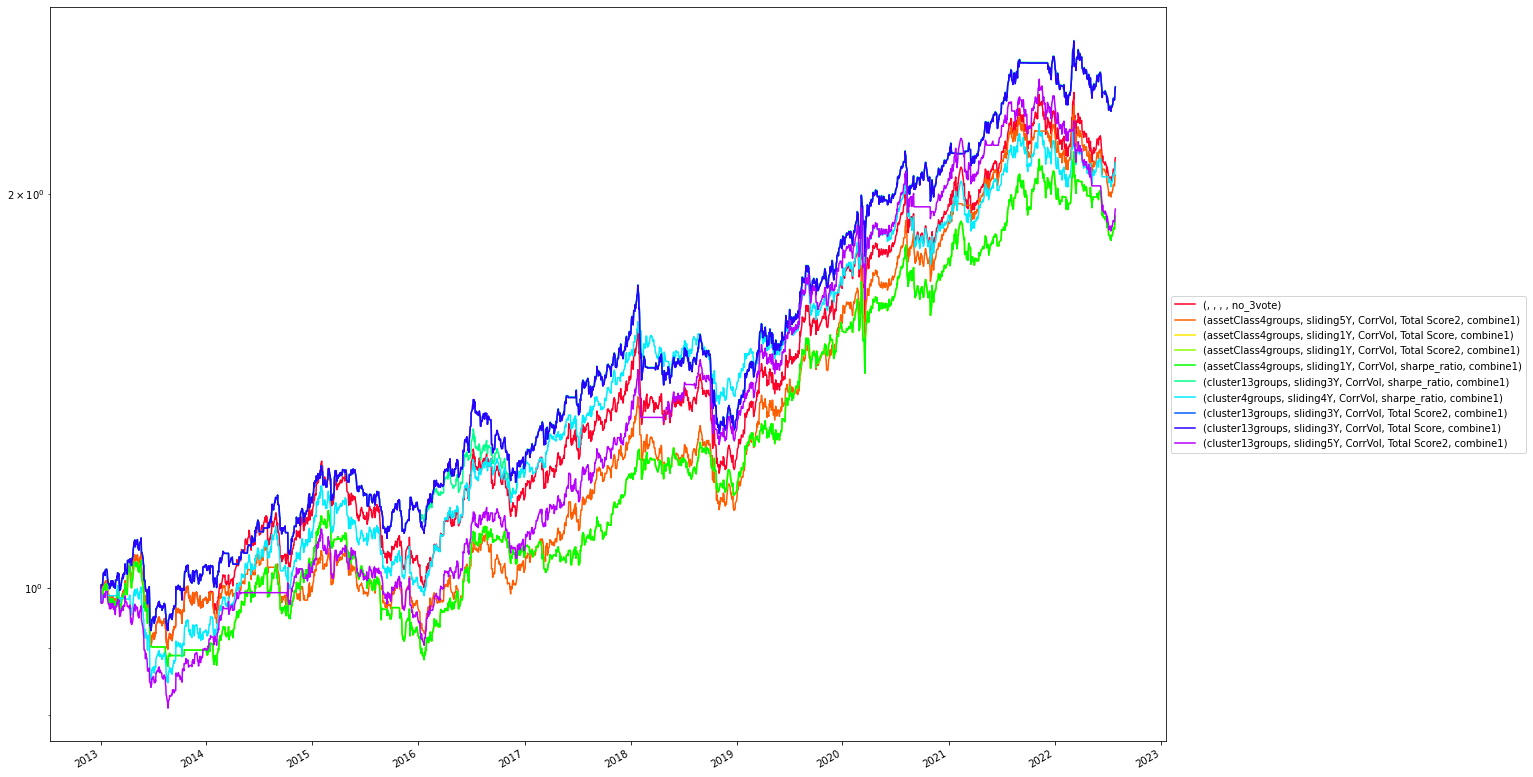

In [225]:
show_ret = pd.concat([base_case_ret, all_ret_df[show_df.index[1:10]]], axis=1)
show_cum_ret(show_ret[start:])

In [226]:
groupby_items = ['correlate_assets', 'sliding_year', 'case_metrics']

all_met_df_count = all_met_df.loc[all_met_df.index.get_level_values('case_combine') != base_case_name, :]
show_df_count = show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
base_met_single_index = base_case_met.copy()
base_met_single_index.index = [base_case_name]


for gb in groupby_items:
    print("================================================== ", gb)

    ser1 = show_df_count.groupby(gb).count().mean(axis=1)
    ser2 = all_met_df_count.groupby(gb).count().mean(axis=1)
    ser3 = ser1 / ser2
    df = pd.concat([ser1.to_frame(), ser2.to_frame(), ser3.to_frame()], axis=1)
    df.columns = ['better', 'total', 'pct']
    display(df)

    perf = all_met_df_count.groupby(gb).mean()
    perf = pd.concat([base_met_single_index, perf])
    display("average: ", perf)

    perf_std = all_met_df_count.groupby(gb).max()
    display("max: ", perf_std)

    perf_std = all_met_df_count.groupby(gb).min()
    display("min: ", perf_std)

    perf_std = all_met_df_count.groupby(gb).std()
    display("std: ", perf_std)

==================================================  correlate_assets


,better,total,pct
correlate_assets,,,
assetClass4groups,11.0,24.0,0.458333
cluster13groups,6.0,24.0,0.250000
cluster4groups,3.0,24.0,0.125000


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
assetClass4groups,0.893751,0.101548,0.847182,0.122829,-0.167094,-0.041301,0.613632,2.497580,84.718172,105.077386,83.290577,95.869856,3.908176,3.701669,0.933459,0.043178
cluster13groups,0.748773,0.087183,0.758437,0.118910,-0.216716,-0.053167,0.409034,1.778241,75.843689,104.359146,78.328361,94.683274,3.144517,2.878681,0.860826,0.043178
cluster4groups,0.763128,0.089798,0.761418,0.122851,-0.168646,-0.046037,0.542925,1.986292,76.141779,104.489911,83.135392,95.396280,3.412850,3.182664,0.929079,0.041969


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
correlate_assets,,,,,,,,,,,,,,,,
assetClass4groups,1.142187,0.122996,0.998002,0.127577,-0.145694,-0.032989,0.801075,3.601380,99.800217,106.149810,85.430574,96.701075,4.822109,4.657163,0.981269,0.067715
cluster13groups,1.102399,0.119795,0.991533,0.124213,-0.158221,-0.041445,0.543260,2.807443,99.153333,105.989747,84.177852,95.855466,4.408992,4.163350,0.966767,0.056832
cluster4groups,1.103261,0.119865,0.990162,0.127544,-0.143559,-0.038121,0.834954,3.144303,99.016200,105.993242,85.644142,96.187872,4.832341,4.641735,0.984894,0.065296


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
correlate_assets,,,,,,,,,,,,,,,,
assetClass4groups,0.577578,0.071883,0.651293,0.116806,-0.181172,-0.047955,0.396764,1.670536,65.129335,103.594135,81.882765,95.204524,2.710019,2.494870,0.790332,0.029021
cluster13groups,0.245258,0.033962,0.338820,0.108517,-0.236707,-0.084315,0.144425,0.402804,33.882015,101.698119,76.329335,91.568501,0.688131,0.266556,0.708157,0.022975
cluster4groups,0.605682,0.074768,0.640741,0.117216,-0.208694,-0.057441,0.358268,1.332995,64.074115,103.738423,79.130566,94.255888,2.534076,2.253623,0.838066,0.024184


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
correlate_assets,,,,,,,,,,,,,,,,
assetClass4groups,0.169538,0.015415,0.107482,0.003296,0.013180,0.003852,0.115493,0.551761,10.748189,0.770726,1.317988,0.385247,0.637112,0.647868,0.063030,0.011480
cluster13groups,0.265895,0.026212,0.193601,0.005058,0.031257,0.012839,0.122392,0.691876,19.360075,1.310588,3.125741,1.283877,1.103117,1.158397,0.082020,0.010151
cluster4groups,0.136914,0.012478,0.093994,0.003331,0.023212,0.005270,0.115316,0.445245,9.399373,0.623925,2.321213,0.526975,0.557785,0.573633,0.046326,0.010929


==================================================  sliding_year


,better,total,pct
sliding_year,,,
sliding1Y,3.0,9.0,0.333333
sliding3Y,3.0,9.0,0.333333
sliding4Y,6.0,9.0,0.666667
sliding5Y,6.0,9.0,0.666667
sliding6Y,2.0,9.0,0.222222
sliding2Y,NaN,9.0,NaN
sliding7Y,NaN,9.0,NaN
sliding8Y,NaN,9.0,NaN


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
sliding1Y,0.841445,0.096801,0.849192,0.116620,-0.165697,-0.042629,0.597919,2.407971,84.919230,104.840062,83.430327,95.737145,3.901484,3.688341,0.855388,0.058041
sliding2Y,0.679738,0.081782,0.718069,0.118853,-0.153391,-0.041363,0.539602,2.003124,71.806871,104.089102,84.660902,95.863748,3.232299,3.025486,0.874924,0.039097
sliding3Y,0.917176,0.103772,0.872240,0.121605,-0.197586,-0.047196,0.525804,2.197541,87.223982,105.188625,80.241388,95.280436,3.892131,3.656153,0.927627,0.046084
sliding4Y,0.767333,0.087432,0.742986,0.121611,-0.184506,-0.054623,0.530360,2.019657,74.298636,104.371581,81.549439,94.537673,3.229562,2.956446,0.920577,0.047293
sliding5Y,0.965364,0.108012,0.887000,0.124492,-0.194746,-0.045026,0.561271,2.428341,88.699958,105.400609,80.525402,95.497382,4.001329,3.776198,0.941994,0.038828
sliding6Y,0.875832,0.100326,0.822878,0.125839,-0.198845,-0.047939,0.515906,2.131132,82.287840,105.016285,80.115466,95.206145,3.621794,3.382101,0.966969,0.033992
sliding7Y,0.768973,0.090588,0.762001,0.123893,-0.183252,-0.045883,0.507989,1.981452,76.200102,104.529424,81.674809,95.411656,3.346688,3.117271,0.931588,0.041381
sliding8Y,0.599211,0.074030,0.657731,0.119327,-0.195195,-0.050024,0.396060,1.529750,65.773088,103.701493,80.480480,94.997575,2.682828,2.432706,0.843236,0.037485


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,1.090245,0.118807,0.993924,0.121090,-0.148309,-0.032989,0.801075,3.601380,99.392422,105.940340,85.169077,96.701075,4.822109,4.657163,0.943807,0.067715
sliding2Y,0.857623,0.098887,0.821161,0.124267,-0.144568,-0.038185,0.678730,2.589672,82.116120,104.944352,85.543228,96.181484,3.871770,3.680844,0.977039,0.045949
sliding3Y,1.102399,0.119795,0.991533,0.123697,-0.174802,-0.043906,0.578861,2.438402,99.153333,105.989747,82.519816,95.609372,4.408992,4.163350,0.949245,0.065296
sliding4Y,1.103261,0.119865,0.990162,0.124587,-0.143559,-0.038121,0.834954,3.144303,99.016200,105.993242,85.644142,96.187872,4.832341,4.641735,0.978248,0.056832
sliding5Y,1.142187,0.122996,0.998002,0.127180,-0.168745,-0.041445,0.678891,2.912962,99.800217,106.149810,83.125519,95.855466,4.699130,4.488011,0.981269,0.049577
sliding6Y,1.006359,0.111851,0.895124,0.127577,-0.165401,-0.042563,0.676240,2.627892,89.512444,105.592541,83.459900,95.743706,4.207871,3.995057,0.984894,0.048368
sliding7Y,0.858311,0.098949,0.812970,0.125835,-0.147213,-0.040492,0.598237,2.269257,81.296968,104.947452,85.278728,95.950772,3.732589,3.514568,0.972205,0.048368
sliding8Y,0.690219,0.083198,0.705430,0.124703,-0.147213,-0.042786,0.565156,1.937190,70.543025,104.159910,85.278728,95.721375,3.207079,2.992339,0.914804,0.041112


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,0.715416,0.085642,0.739321,0.108517,-0.190559,-0.049427,0.449422,1.739053,73.932147,104.282078,80.944051,95.057348,3.172018,2.944668,0.708157,0.050786
sliding2Y,0.566757,0.070760,0.651778,0.115075,-0.169911,-0.044640,0.416453,1.585130,65.177840,103.537995,83.008905,95.536018,2.763137,2.539938,0.809668,0.033857
sliding3Y,0.658947,0.080122,0.685127,0.119289,-0.229530,-0.052217,0.458362,1.670793,68.512693,104.006124,77.047010,94.778279,2.952238,2.712464,0.902115,0.022975
sliding4Y,0.245258,0.033962,0.338820,0.119783,-0.235156,-0.084315,0.144425,0.402804,33.882015,101.698119,76.484359,91.568501,0.688131,0.266556,0.830816,0.033857
sliding5Y,0.783042,0.092052,0.760352,0.120662,-0.234321,-0.049422,0.460668,1.862578,76.035156,104.602600,76.567922,95.057817,3.418294,3.171185,0.879154,0.029021
sliding6Y,0.743331,0.088313,0.727498,0.122800,-0.234942,-0.057441,0.423170,1.537456,72.749788,104.415661,76.505753,94.255888,3.035584,2.748378,0.894864,0.024184
sliding7Y,0.664450,0.080667,0.684409,0.119804,-0.234942,-0.048499,0.407572,1.724752,68.440851,104.033363,76.505753,95.150124,3.073575,2.839661,0.845921,0.036276
sliding8Y,0.513768,0.065165,0.599637,0.115887,-0.236707,-0.063331,0.275298,1.028966,59.963686,103.258248,76.329335,93.666945,2.140476,1.823823,0.790332,0.033857


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,0.186605,0.016505,0.113304,0.006088,0.019135,0.007430,0.157692,0.897239,11.330417,0.825237,1.913467,0.742971,0.728752,0.760515,0.111165,0.007551
sliding2Y,0.135028,0.013006,0.078367,0.004166,0.012400,0.002796,0.114200,0.452977,7.836661,0.650291,1.239958,0.279596,0.496755,0.510179,0.077567,0.005374
sliding3Y,0.153290,0.013495,0.097218,0.001802,0.024674,0.003336,0.036468,0.219146,9.721795,0.674745,2.467355,0.333613,0.450687,0.443140,0.018344,0.016771
sliding4Y,0.375356,0.037977,0.286230,0.001591,0.040325,0.021602,0.291614,1.197856,28.622971,1.898874,4.032521,2.160179,1.816511,1.924314,0.067706,0.007916
sliding5Y,0.144125,0.012552,0.098599,0.002768,0.030165,0.003455,0.075682,0.442072,9.859888,0.627598,3.016498,0.345465,0.479379,0.494835,0.048133,0.007241
sliding6Y,0.104032,0.009310,0.068503,0.001931,0.030660,0.005423,0.100368,0.399350,6.850252,0.465518,3.065969,0.542283,0.409847,0.435018,0.028116,0.007916
sliding7Y,0.085319,0.008067,0.059866,0.001884,0.039393,0.002777,0.079311,0.220912,5.986643,0.403351,3.939278,0.277680,0.255586,0.263115,0.043989,0.004635
sliding8Y,0.057203,0.005806,0.032268,0.003839,0.036308,0.009008,0.106284,0.330117,3.226755,0.290294,3.630838,0.900757,0.351512,0.388293,0.055106,0.002094


==================================================  case_metrics


,better,total,pct
case_metrics,,,
Total Score,7.0,24.0,0.291667
Total Score2,7.0,24.0,0.291667
sharpe_ratio,6.0,24.0,0.250000


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
Total Score,0.811011,0.093680,0.794152,0.121712,-0.183084,-0.046787,0.529135,2.109870,79.415159,104.683994,81.691631,95.321309,3.523739,3.289804,0.911153,0.042523
Total Score2,0.812399,0.093763,0.795657,0.121538,-0.183084,-0.046296,0.529714,2.126271,79.565671,104.688164,81.691631,95.370435,3.531682,3.300203,0.909894,0.042624
sharpe_ratio,0.782242,0.091086,0.777228,0.121340,-0.186289,-0.047423,0.506742,2.025972,77.722810,104.554285,81.371068,95.257666,3.410122,3.173006,0.902316,0.043178


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,1.100184,0.119615,0.993924,0.127577,-0.143559,-0.032989,0.801075,3.60138,99.392422,105.980759,85.644142,96.701075,4.822109,4.657163,0.984894,0.067715
Total Score2,1.142187,0.122996,0.998002,0.127577,-0.143559,-0.032989,0.801075,3.60138,99.800217,106.149810,85.644142,96.701075,4.822109,4.657163,0.984894,0.067715
sharpe_ratio,1.103261,0.119865,0.993924,0.127544,-0.143559,-0.032989,0.834954,3.60138,99.392422,105.993242,85.644142,96.701075,4.832341,4.657163,0.983686,0.067715


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,0.245258,0.033962,0.338820,0.108517,-0.236707,-0.084315,0.144425,0.402804,33.882015,101.698119,76.329335,91.568501,0.688131,0.266556,0.708157,0.022975
Total Score2,0.245258,0.033962,0.338820,0.108517,-0.236707,-0.084315,0.144425,0.402804,33.882015,101.698119,76.329335,91.568501,0.688131,0.266556,0.708157,0.022975
sharpe_ratio,0.323707,0.043626,0.416436,0.108517,-0.236707,-0.081322,0.185518,0.536457,41.643562,102.181285,76.329335,91.867813,1.124525,0.717915,0.708157,0.026602


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,0.209126,0.020146,0.145549,0.004476,0.033393,0.009920,0.144607,0.645509,14.554866,1.007277,3.339311,0.991968,0.864774,0.904668,0.074159,0.011291
Total Score2,0.214726,0.020581,0.148986,0.004414,0.033393,0.009431,0.146636,0.647198,14.898642,1.029035,3.339311,0.943054,0.884333,0.921536,0.073405,0.010633
sharpe_ratio,0.202633,0.019191,0.139891,0.004324,0.033365,0.009690,0.146217,0.652497,13.989064,0.959560,3.336526,0.969021,0.841190,0.879788,0.073299,0.010700


# Stage4:

Sliding lookback window to choose 
- the threshold
- the condition case
- the correlation asset case

In [227]:
base_folder = './result/2022/cashON_signal/result/yearly_threshold/FixCorrAssetB2012_13ETFs_combine1Only/'
sliding_case_name = 'FixCorrAssetB2012-Combine4corrAsset'

In [228]:
all_ret = {}
all_met = {}
for f in os.listdir(base_folder):
    try:
        case_folder = os.path.join(base_folder, f)
        
        case_type2 = f.split('_')
        if len(case_type2) > 2:
            case_type2 = [case_type2[0], "_".join(case_type2[1:])]
        case_type2 = [sliding_case_name] + case_type2
        print(case_type2)

        ret = pd.read_csv(os.path.join(case_folder, 'final_ret.csv'), index_col=0)
        names = ['case_metrics', 'case_combine']
        ret.columns = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in ret.columns], names=names)
        ret.index = pd.to_datetime(ret.index)
        all_ret[tuple(case_type2)] = ret
        met = pd.read_csv(os.path.join(case_folder, 'final_metrics.csv'), index_col=0)
        names = ['case_metrics', 'case_combine']
        met.index = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in met.index], names=names)
        all_met[tuple(case_type2)] = met
    except:
        print("Failed for {}".format(f))
    # break
all_ret_df = pd.concat(all_ret.values(), keys=all_ret.keys(), axis=1)
# all_met_df = pd.concat(all_met.values(), keys=all_met.keys())

['FixCorrAssetB2012-Combine4corrAsset', 'met(from2016).csv']
Failed for met(from2016).csv
['FixCorrAssetB2012-Combine4corrAsset', 'sliding1Y', 'CorrVol']
['FixCorrAssetB2012-Combine4corrAsset', 'sliding2Y', 'CorrVol']
['FixCorrAssetB2012-Combine4corrAsset', 'sliding3Y', 'CorrVol']
['FixCorrAssetB2012-Combine4corrAsset', 'sliding4Y', 'CorrVol']
['FixCorrAssetB2012-Combine4corrAsset', 'sliding5Y', 'CorrVol']
['FixCorrAssetB2012-Combine4corrAsset', 'sliding6Y', 'CorrVol']
['FixCorrAssetB2012-Combine4corrAsset', 'sliding7Y', 'CorrVol']
['FixCorrAssetB2012-Combine4corrAsset', 'sliding8Y', 'CorrVol']


In [229]:
# 13ETFs	v1	sliding1Y	2thresholds	combine2	no_3vote
idx_names = ['correlate_assets', 'sliding_year', 'case_pool', 'case_metrics', 'case_combine']
all_ret_df.columns.names = idx_names
# all_met_df.index.names = idx_names
# all_ret_df_dict[sliding_case_name] = all_ret_df
# all_ret_df.dropna()

In [230]:
all_met_df = empy_metric(all_ret_df[start:].dropna())
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df[start:].dropna())], axis=1)
# all_met_df_dict[sliding_case_name] = all_met_df
# all_met_df.head()

In [231]:
all_met_df.to_csv(os.path.join(base_folder, 'met(from{}).csv'.format(start)))

In [232]:
base_case_name = 'no_3vote'
base_case_ret = all_ret_df.loc[:, all_ret_df.columns.get_level_values('case_combine') == base_case_name].iloc[:, [0]]
base_case_ret.columns = pd.MultiIndex.from_tuples([("", "", "", "", base_case_name)], names=idx_names)
# display(base_case_ret)
base_case_met = all_met_df.loc[all_met_df.index.get_level_values('case_combine') == base_case_name, :].iloc[[0], :]
base_case_met.index = pd.MultiIndex.from_tuples([("", "", "", "", base_case_name)], names=idx_names)
base_case_met

,,,,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
correlate_assets,sliding_year,case_pool,case_metrics,case_combine,,,,,,,,,,,,,,,,
,,,,no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.70045,94.454598,3.821084,3.543814,1.0,0.0


In [233]:
sort_by = 'sharpe_ratio'
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
show_df = pd.concat([base_case_met, show_df])
show_df.head(20)

total_return  \
correlate_assets                    sliding_year case_pool case_metrics case_combine                 
                                                                        no_3vote          1.041942   
FixCorrAssetB2012-Combine4corrAsset sliding5Y    CorrVol   Total Score2 combine1          1.125228   
                                                           Total Score  combine1          1.125228   
                                                           sharpe_ratio combine1          0.992897   

                                                                                      annual_return  \
correlate_assets                    sliding_year case_pool case_metrics case_combine                  
                                                                        no_3vote           0.114831   
FixCorrAssetB2012-Combine4corrAsset sliding5Y    CorrVol   Total Score2 combine1           0.121638   
                                                           Total Score  combine1           0.121638   
                                                           sharpe_ratio combine1           0.110712   

                                                                                      sharpe_ratio  \
correlate_assets                    sliding_year case_pool case_metrics case_combine                 
                                                                        no_3vote          0.872381   
FixCorrAssetB2012-Combine4corrAsset sliding5Y    CorrVol   Total Score2 combine1          0.984072   
                                                           Total Score  combine1          0.984072   
                                                           sharpe_ratio combine1          0.905314   

                                                                                      annual_volatility  \
correlate_assets                    sliding_year case_pool case_metrics case_combine                      
                                                                        no_3vote               0.135112   
FixCorrAssetB2012-Combine4corrAsset sliding5Y    CorrVol   Total Score2 combine1               0.124568   
                                                           Total Score  combine1               0.124568   
                                                           sharpe_ratio combine1               0.124591   

                                                                                      max_drawdown  \
correlate_assets                    sliding_year case_pool case_metrics case_combine                 
                                                                        no_3vote         -0.222995   
FixCorrAssetB2012-Combine4corrAsset sliding5Y    CorrVol   Total Score2 combine1         -0.148163   
                                                           Total Score  combine1         -0.148163   
                                                           sharpe_ratio combine1         -0.148163   

                                                                                      avg_drawdown  \
correlate_assets                    sliding_year case_pool case_metrics case_combine                 
                                                                        no_3vote         -0.055454   
FixCorrAssetB2012-Combine4corrAsset sliding5Y    CorrVol   Total Score2 combine1         -0.038107   
                                                           Total Score  combine1         -0.038107   
                                                           sharpe_ratio combine1         -0.040281   

                                                                                      return/maxdd  \
correlate_assets                    sliding_year case_pool case_metrics case_combine                 
                                                                        no_3vote          0.514948   
FixCorrAssetB2012-Combine4corrAsset sliding5Y    CorrVol   Total S

In [234]:
groupby_items = [
    'sliding_year', 'case_metrics',
    ['sliding_year', 'case_metrics']
]

all_met_df_count = all_met_df.loc[all_met_df.index.get_level_values('case_combine') != base_case_name, :]
show_df_count = show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
base_met_single_index = base_case_met.copy()
base_met_single_index.index = [base_case_name]


for gb in groupby_items:
    print("================================================== ", gb)
    ser1 = show_df_count.groupby(gb).count().mean(axis=1)
    ser2 = all_met_df_count.groupby(gb).count().mean(axis=1)
    ser3 = ser1 / ser2
    df = pd.concat([ser1.to_frame(), ser2.to_frame(), ser3.to_frame()], axis=1)
    df.columns = ['better', 'total', 'pct']
    display(df)

    perf = all_met_df_count.groupby(gb).mean()
    perf = pd.concat([base_met_single_index, perf])
    display("average: ", perf)

    perf_std = all_met_df_count.groupby(gb).max()
    display("max: ", perf_std)

    perf_std = all_met_df_count.groupby(gb).min()
    display("min: ", perf_std)

    perf_std = all_met_df_count.groupby(gb).std()
    display("std: ", perf_std)

==================================================  sliding_year


,better,total,pct
sliding_year,,,
sliding5Y,3.0,3.0,1.0
sliding1Y,NaN,3.0,NaN
sliding2Y,NaN,3.0,NaN
sliding3Y,NaN,3.0,NaN
sliding4Y,NaN,3.0,NaN
sliding6Y,NaN,3.0,NaN
sliding7Y,NaN,3.0,NaN
sliding8Y,NaN,3.0,NaN


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
sliding1Y,0.600887,0.074279,0.692615,0.112639,-0.190559,-0.056712,0.389795,1.309767,69.261477,103.713958,80.944051,94.328827,2.881672,2.598114,0.788520,0.074970
sliding2Y,0.450640,0.058279,0.544180,0.116613,-0.174902,-0.049113,0.333207,1.186611,54.417988,102.913929,82.509812,95.088652,2.137783,1.892216,0.822961,0.048368
sliding3Y,0.864772,0.099530,0.838519,0.122080,-0.229530,-0.059391,0.433625,1.676891,83.851925,104.976496,77.047010,94.060859,3.542596,3.245639,0.902920,0.030633
sliding4Y,0.521837,0.066028,0.588503,0.121148,-0.221480,-0.066294,0.298120,0.995983,58.850343,103.301379,77.852031,93.370613,2.165257,1.833787,0.855589,0.045949
sliding5Y,1.081118,0.117996,0.957819,0.124576,-0.148163,-0.038832,0.796390,3.044174,95.781927,105.899793,85.183662,96.116842,4.638259,4.444101,0.922860,0.039903
sliding6Y,0.842287,0.097497,0.801532,0.126006,-0.165401,-0.045145,0.589456,2.159719,80.153223,104.874828,83.459900,95.485512,3.668139,3.442415,0.972608,0.045949
sliding7Y,0.805294,0.093856,0.786381,0.123710,-0.191547,-0.046161,0.489992,2.046801,78.638126,104.692814,80.845341,95.383895,3.443455,3.212650,0.955287,0.052398
sliding8Y,0.434699,0.056498,0.525551,0.117798,-0.232489,-0.060537,0.243013,0.938201,52.555112,102.824897,76.751057,93.946336,1.747798,1.445115,0.828197,0.035067


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,0.600887,0.074279,0.692615,0.112639,-0.190559,-0.056712,0.389795,1.309767,69.261477,103.713958,80.944051,94.328827,2.881672,2.598114,0.788520,0.074970
sliding2Y,0.450640,0.058279,0.544180,0.116613,-0.174902,-0.049113,0.333207,1.186611,54.417988,102.913929,82.509812,95.088652,2.137783,1.892216,0.822961,0.048368
sliding3Y,0.866083,0.099648,0.847215,0.122742,-0.229530,-0.057332,0.434138,1.738072,84.721457,104.982380,77.047010,94.266775,3.586661,3.300000,0.904532,0.036276
sliding4Y,0.521837,0.066028,0.588503,0.121148,-0.221480,-0.066294,0.298120,0.995983,58.850343,103.301379,77.852031,93.370613,2.165257,1.833787,0.855589,0.045949
sliding5Y,1.125228,0.121638,0.984072,0.124591,-0.148163,-0.038107,0.820972,3.192012,98.407205,106.081897,85.183662,96.189302,4.787733,4.597198,0.934139,0.039903
sliding6Y,0.862521,0.099328,0.815179,0.126043,-0.165401,-0.044992,0.600527,2.207681,81.517883,104.966386,83.459900,95.500812,3.745528,3.520568,0.972810,0.045949
sliding7Y,0.881681,0.101042,0.836671,0.124319,-0.191547,-0.044697,0.527507,2.260621,83.667092,105.052112,80.845341,95.530332,3.730833,3.507349,0.966767,0.055623
sliding8Y,0.439649,0.057054,0.528298,0.118300,-0.232489,-0.053890,0.245404,1.027761,52.829778,102.852690,76.751057,94.610984,1.764311,1.445322,0.829607,0.037485


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,0.600887,0.074279,0.692615,0.112639,-0.190559,-0.056712,0.389795,1.309767,69.261477,103.713958,80.944051,94.328827,2.881672,2.598114,0.788520,0.074970
sliding2Y,0.450640,0.058279,0.544180,0.116613,-0.174902,-0.049113,0.333207,1.186611,54.417988,102.913929,82.509812,95.088652,2.137783,1.892216,0.822961,0.048368
sliding3Y,0.864116,0.099471,0.834172,0.120756,-0.229530,-0.060421,0.433369,1.646300,83.417159,104.973554,77.047010,93.957901,3.520564,3.218459,0.899698,0.027811
sliding4Y,0.521837,0.066028,0.588503,0.121148,-0.221480,-0.066294,0.298120,0.995983,58.850343,103.301379,77.852031,93.370613,2.165257,1.833787,0.855589,0.045949
sliding5Y,0.992897,0.110712,0.905314,0.124568,-0.148163,-0.040281,0.747227,2.748498,90.531370,105.535583,85.183662,95.971922,4.339310,4.137906,0.917221,0.039903
sliding6Y,0.832170,0.096581,0.794709,0.125931,-0.165401,-0.045221,0.583920,2.135737,79.470893,104.829049,83.459900,95.477863,3.629445,3.403338,0.972205,0.045949
sliding7Y,0.652522,0.079484,0.685802,0.122493,-0.191547,-0.049090,0.414961,1.619163,68.580196,103.974219,80.845341,95.091020,2.868699,2.623250,0.932326,0.050786
sliding8Y,0.424799,0.055386,0.520058,0.116796,-0.232489,-0.063860,0.238231,0.893422,52.005780,102.769309,76.751057,93.614012,1.714773,1.445011,0.825378,0.033857


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding2Y,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding3Y,0.001135,0.000102,0.007530,0.001147,2.263399e-16,0.001783,0.000444,0.052985,0.753037,0.005096,1.740467e-14,0.178328,0.038161,0.047078,0.002791,0.004887
sliding4Y,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding5Y,0.076401,0.006308,0.045471,0.000013,4.007774e-16,0.001255,0.042577,0.256063,4.547115,0.315415,4.019437e-14,0.125504,0.258897,0.265172,0.009768,0.000000
sliding6Y,0.017523,0.001586,0.011818,0.000065,0.000000e+00,0.000132,0.009588,0.041537,1.181830,0.079292,0.000000e+00,0.013250,0.067021,0.067683,0.000349,0.000000
sliding7Y,0.132305,0.012446,0.087104,0.001054,6.206335e-17,0.002536,0.064979,0.370346,8.710423,0.622322,1.004859e-14,0.253637,0.497753,0.510435,0.019885,0.002793
sliding8Y,0.008574,0.000963,0.004757,0.000868,4.807407e-17,0.005756,0.004141,0.077561,0.475735,0.048140,0.000000e+00,0.575602,0.028601,0.000179,0.002442,0.002094


==================================================  case_metrics


,better,total,pct
case_metrics,,,
Total Score,1.0,8.0,0.125
Total Score2,1.0,8.0,0.125
sharpe_ratio,1.0,8.0,0.125


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
Total Score,0.714526,0.084296,0.725402,0.120796,-0.194259,-0.053053,0.454037,1.702557,72.540242,104.214821,80.574108,94.694688,3.077200,2.811934,0.882251,0.045949
Total Score2,0.712670,0.084088,0.724372,0.120608,-0.194259,-0.051807,0.453140,1.719349,72.437242,104.204398,80.574108,94.819309,3.071007,2.811973,0.881722,0.046403
sharpe_ratio,0.673379,0.080601,0.700888,0.120309,-0.194259,-0.053459,0.432922,1.587400,70.088812,104.030066,80.574108,94.654079,2.936153,2.668856,0.879381,0.047612


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,1.125228,0.121638,0.984072,0.126043,-0.148163,-0.038107,0.820972,3.192012,98.407205,106.081897,85.183662,96.189302,4.787733,4.597198,0.972810,0.07497
Total Score2,1.125228,0.121638,0.984072,0.126043,-0.148163,-0.038107,0.820972,3.192012,98.407205,106.081897,85.183662,96.189302,4.787733,4.597198,0.972810,0.07497
sharpe_ratio,0.992897,0.110712,0.905314,0.125931,-0.148163,-0.040281,0.747227,2.748498,90.531370,105.535583,85.183662,95.971922,4.339310,4.137906,0.972205,0.07497


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,0.439649,0.057054,0.528298,0.112639,-0.232489,-0.066294,0.245404,0.893422,52.829778,102.852690,76.751057,93.370613,1.764311,1.445011,0.78852,0.027811
Total Score2,0.424799,0.055386,0.520058,0.112639,-0.232489,-0.066294,0.238231,0.995983,52.005780,102.769309,76.751057,93.370613,1.714773,1.445322,0.78852,0.027811
sharpe_ratio,0.439649,0.057054,0.528298,0.112639,-0.232489,-0.066294,0.245404,0.893422,52.829778,102.852690,76.751057,93.370613,1.764311,1.445011,0.78852,0.033857


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,0.247291,0.023632,0.163634,0.004603,0.031168,0.010211,0.186663,0.783322,16.363417,1.181581,3.116752,1.021098,1.023353,1.062520,0.068501,0.014057
Total Score2,0.249693,0.023912,0.165072,0.004748,0.031168,0.009269,0.187822,0.764717,16.507171,1.195598,3.116752,0.926853,1.032541,1.062463,0.068980,0.013664
sharpe_ratio,0.209727,0.020447,0.143196,0.004345,0.031168,0.009117,0.165763,0.635352,14.319561,1.022335,3.116752,0.911690,0.899167,0.932528,0.064712,0.013070


==================================================  ['sliding_year', 'case_metrics']


better  total  pct
sliding_year case_metrics                    
sliding5Y    Total Score      1.0    1.0  1.0
             Total Score2     1.0    1.0  1.0
             sharpe_ratio     1.0    1.0  1.0
sliding1Y    Total Score      NaN    1.0  NaN
             Total Score2     NaN    1.0  NaN
             sharpe_ratio     NaN    1.0  NaN
sliding2Y    Total Score      NaN    1.0  NaN
             Total Score2     NaN    1.0  NaN
             sharpe_ratio     NaN    1.0  NaN
sliding3Y    Total Score      NaN    1.0  NaN
             Total Score2     NaN    1.0  NaN
             sharpe_ratio     NaN    1.0  NaN
sliding4Y    Total Score      NaN    1.0  NaN
             Total Score2     NaN    1.0  NaN
             sharpe_ratio     NaN    1.0  NaN
sliding6Y    Total Score      NaN    1.0  NaN
             Total Score2     NaN    1.0  NaN
             sharpe_ratio     NaN    1.0  NaN
sliding7Y    Total Score      NaN    1.0  NaN
             Total Score2     NaN    1.0  NaN
             sharpe_ratio     NaN    1.0  NaN
sliding8Y    Total Score      NaN    1.0  NaN
             Total Score2     NaN    1.0  NaN
             sharpe_ratio     NaN    1.0  NaN

'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
"(sliding1Y, Total Score)",0.600887,0.074279,0.692615,0.112639,-0.190559,-0.056712,0.389795,1.309767,69.261477,103.713958,80.944051,94.328827,2.881672,2.598114,0.788520,0.074970
"(sliding1Y, Total Score2)",0.600887,0.074279,0.692615,0.112639,-0.190559,-0.056712,0.389795,1.309767,69.261477,103.713958,80.944051,94.328827,2.881672,2.598114,0.788520,0.074970
"(sliding1Y, sharpe_ratio)",0.600887,0.074279,0.692615,0.112639,-0.190559,-0.056712,0.389795,1.309767,69.261477,103.713958,80.944051,94.328827,2.881672,2.598114,0.788520,0.074970
"(sliding2Y, Total Score)",0.450640,0.058279,0.544180,0.116613,-0.174902,-0.049113,0.333207,1.186611,54.417988,102.913929,82.509812,95.088652,2.137783,1.892216,0.822961,0.048368
"(sliding2Y, Total Score2)",0.450640,0.058279,0.544180,0.116613,-0.174902,-0.049113,0.333207,1.186611,54.417988,102.913929,82.509812,95.088652,2.137783,1.892216,0.822961,0.048368
"(sliding2Y, sharpe_ratio)",0.450640,0.058279,0.544180,0.116613,-0.174902,-0.049113,0.333207,1.186611,54.417988,102.913929,82.509812,95.088652,2.137783,1.892216,0.822961,0.048368
"(sliding3Y, Total Score)",0.864116,0.099471,0.834172,0.122742,-0.229530,-0.060421,0.433369,1.646300,83.417159,104.973554,77.047010,93.957901,3.520564,3.218459,0.904532,0.027811
"(sliding3Y, Total Score2)",0.864116,0.099471,0.834172,0.122742,-0.229530,-0.060421,0.433369,1.646300,83.417159,104.973554,77.047010,93.957901,3.520564,3.218459,0.904532,0.027811
"(sliding3Y, sharpe_ratio)",0.866083,0.099648,0.847215,0.120756,-0.229530,-0.057332,0.434138,1.738072,84.721457,104.982380,77.047010,94.266775,3.586661,3.300000,0.899698,0.036276


'max: '

total_return  annual_return  sharpe_ratio  \
sliding_year case_metrics                                              
sliding1Y    Total Score       0.600887       0.074279      0.692615   
             Total Score2      0.600887       0.074279      0.692615   
             sharpe_ratio      0.600887       0.074279      0.692615   
sliding2Y    Total Score       0.450640       0.058279      0.544180   
             Total Score2      0.450640       0.058279      0.544180   
             sharpe_ratio      0.450640       0.058279      0.544180   
sliding3Y    Total Score       0.864116       0.099471      0.834172   
             Total Score2      0.864116       0.099471      0.834172   
             sharpe_ratio      0.866083       0.099648      0.847215   
sliding4Y    Total Score       0.521837       0.066028      0.588503   
             Total Score2      0.521837       0.066028      0.588503   
             sharpe_ratio      0.521837       0.066028      0.588503   
sliding5Y    Total Score       1.125228       0.121638      0.984072   
             Total Score2      1.125228       0.121638      0.984072   
             sharpe_ratio      0.992897       0.110712      0.905314   
sliding6Y    Total Score       0.832170       0.096581      0.794709   
             Total Score2      0.832170       0.096581      0.794709   
             sharpe_ratio      0.862521       0.099328      0.815179   
sliding7Y    Total Score       0.881681       0.101042      0.836671   
             Total Score2      0.881681       0.101042      0.836671   
             sharpe_ratio      0.652522       0.079484      0.685802   
sliding8Y    Total Score       0.439649       0.057054      0.528298   
             Total Score2      0.424799       0.055386      0.520058   
             sharpe_ratio      0.439649       0.057054      0.528298   

                           annual_volatility  max_drawdown  avg_drawdown  \
sliding_year case_metrics                                                  
sliding1Y    Total Score            0.112639     -0.190559     -0.056712   
             Total Score2           0.112639     -0.190559     -0.056712   
             sharpe_ratio           0.112639     -0.190559     -0.056712   
sliding2Y    Total Score            0.116613     -0.174902     -0.049113   
             Total Score2           0.116613     -0.174902     -0.049113   
             sharpe_ratio           0.116613     -0.174902     -0.049113   
sliding3Y    Total Score            0.122742     -0.229530     -0.060421   
             Total Score2           0.122742     -0.229530     -0.060421   
             sharpe_ratio           0.120756     -0.229530     -0.057332   
sliding4Y    Total Score            0.121148     -0.221480     -0.066294   
             Total Score2           0.121148     -0.221480     -0.066294   
             sharpe_ratio           0.121148     -0.221480     -0.066294   
sliding5Y    Total Score            0.124568     -0.148163     -0.038107   
             Total Score2           0.124568     -0.148163     -0.038107   
             sharpe_ratio           0.124591     -0.148163     -0.040281   
sliding6Y    Total Score            0.126043     -0.165401     -0.045221   
             Total Score2           0.126043     -0.165401     -0.045221   
             sharpe_ratio           0.125931     -0.165401     -0.044992   
sliding7Y    Total Score            0.124319     -0.191547     -0.044697   
             Total Score2           0.124319     -0.191547     -0.044697   
             sharpe_ratio           0.122493     -0.191547     -0.049090   
sliding8Y    Total Score            0.118300     -0.232489     -0.063860   
             Total Score2           0.116796     -0.232489     -0.053890   
             sharpe_ratio           0.118300     -0.232489     -0.063860   

                           return/maxdd  return/avgdd  Sharpe Score  \
sliding_year case_metrics                                             
sliding1Y    Total Score       0.38

'min: '

total_return  annual_return  sharpe_ratio  \
sliding_year case_metrics                                              
sliding1Y    Total Score       0.600887       0.074279      0.692615   
             Total Score2      0.600887       0.074279      0.692615   
             sharpe_ratio      0.600887       0.074279      0.692615   
sliding2Y    Total Score       0.450640       0.058279      0.544180   
             Total Score2      0.450640       0.058279      0.544180   
             sharpe_ratio      0.450640       0.058279      0.544180   
sliding3Y    Total Score       0.864116       0.099471      0.834172   
             Total Score2      0.864116       0.099471      0.834172   
             sharpe_ratio      0.866083       0.099648      0.847215   
sliding4Y    Total Score       0.521837       0.066028      0.588503   
             Total Score2      0.521837       0.066028      0.588503   
             sharpe_ratio      0.521837       0.066028      0.588503   
sliding5Y    Total Score       1.125228       0.121638      0.984072   
             Total Score2      1.125228       0.121638      0.984072   
             sharpe_ratio      0.992897       0.110712      0.905314   
sliding6Y    Total Score       0.832170       0.096581      0.794709   
             Total Score2      0.832170       0.096581      0.794709   
             sharpe_ratio      0.862521       0.099328      0.815179   
sliding7Y    Total Score       0.881681       0.101042      0.836671   
             Total Score2      0.881681       0.101042      0.836671   
             sharpe_ratio      0.652522       0.079484      0.685802   
sliding8Y    Total Score       0.439649       0.057054      0.528298   
             Total Score2      0.424799       0.055386      0.520058   
             sharpe_ratio      0.439649       0.057054      0.528298   

                           annual_volatility  max_drawdown  avg_drawdown  \
sliding_year case_metrics                                                  
sliding1Y    Total Score            0.112639     -0.190559     -0.056712   
             Total Score2           0.112639     -0.190559     -0.056712   
             sharpe_ratio           0.112639     -0.190559     -0.056712   
sliding2Y    Total Score            0.116613     -0.174902     -0.049113   
             Total Score2           0.116613     -0.174902     -0.049113   
             sharpe_ratio           0.116613     -0.174902     -0.049113   
sliding3Y    Total Score            0.122742     -0.229530     -0.060421   
             Total Score2           0.122742     -0.229530     -0.060421   
             sharpe_ratio           0.120756     -0.229530     -0.057332   
sliding4Y    Total Score            0.121148     -0.221480     -0.066294   
             Total Score2           0.121148     -0.221480     -0.066294   
             sharpe_ratio           0.121148     -0.221480     -0.066294   
sliding5Y    Total Score            0.124568     -0.148163     -0.038107   
             Total Score2           0.124568     -0.148163     -0.038107   
             sharpe_ratio           0.124591     -0.148163     -0.040281   
sliding6Y    Total Score            0.126043     -0.165401     -0.045221   
             Total Score2           0.126043     -0.165401     -0.045221   
             sharpe_ratio           0.125931     -0.165401     -0.044992   
sliding7Y    Total Score            0.124319     -0.191547     -0.044697   
             Total Score2           0.124319     -0.191547     -0.044697   
             sharpe_ratio           0.122493     -0.191547     -0.049090   
sliding8Y    Total Score            0.118300     -0.232489     -0.063860   
             Total Score2           0.116796     -0.232489     -0.053890   
             sharpe_ratio           0.118300     -0.232489     -0.063860   

                           return/maxdd  return/avgdd  Sharpe Score  \
sliding_year case_metrics                                             
sliding1Y    Total Score       0.38

'std: '

total_return  annual_return  sharpe_ratio  \
sliding_year case_metrics                                              
sliding1Y    Total Score            NaN            NaN           NaN   
             Total Score2           NaN            NaN           NaN   
             sharpe_ratio           NaN            NaN           NaN   
sliding2Y    Total Score            NaN            NaN           NaN   
             Total Score2           NaN            NaN           NaN   
             sharpe_ratio           NaN            NaN           NaN   
sliding3Y    Total Score            NaN            NaN           NaN   
             Total Score2           NaN            NaN           NaN   
             sharpe_ratio           NaN            NaN           NaN   
sliding4Y    Total Score            NaN            NaN           NaN   
             Total Score2           NaN            NaN           NaN   
             sharpe_ratio           NaN            NaN           NaN   
sliding5Y    Total Score            NaN            NaN           NaN   
             Total Score2           NaN            NaN           NaN   
             sharpe_ratio           NaN            NaN           NaN   
sliding6Y    Total Score            NaN            NaN           NaN   
             Total Score2           NaN            NaN           NaN   
             sharpe_ratio           NaN            NaN           NaN   
sliding7Y    Total Score            NaN            NaN           NaN   
             Total Score2           NaN            NaN           NaN   
             sharpe_ratio           NaN            NaN           NaN   
sliding8Y    Total Score            NaN            NaN           NaN   
             Total Score2           NaN            NaN           NaN   
             sharpe_ratio           NaN            NaN           NaN   

                           annual_volatility  max_drawdown  avg_drawdown  \
sliding_year case_metrics                                                  
sliding1Y    Total Score                 NaN           NaN           NaN   
             Total Score2                NaN           NaN           NaN   
             sharpe_ratio                NaN           NaN           NaN   
sliding2Y    Total Score                 NaN           NaN           NaN   
             Total Score2                NaN           NaN           NaN   
             sharpe_ratio                NaN           NaN           NaN   
sliding3Y    Total Score                 NaN           NaN           NaN   
             Total Score2                NaN           NaN           NaN   
             sharpe_ratio                NaN           NaN           NaN   
sliding4Y    Total Score                 NaN           NaN           NaN   
             Total Score2                NaN           NaN           NaN   
             sharpe_ratio                NaN           NaN           NaN   
sliding5Y    Total Score                 NaN           NaN           NaN   
             Total Score2                NaN           NaN           NaN   
             sharpe_ratio                NaN           NaN           NaN   
sliding6Y    Total Score                 NaN           NaN           NaN   
             Total Score2                NaN           NaN           NaN   
             sharpe_ratio                NaN           NaN           NaN   
sliding7Y    Total Score                 NaN           NaN           NaN   
             Total Score2                NaN           NaN           NaN   
             sharpe_ratio                NaN           NaN           NaN   
sliding8Y    Total Score                 NaN           NaN           NaN   
             Total Score2                NaN           NaN           NaN   
             sharpe_ratio                NaN           NaN           NaN   

                           return/maxdd  return/avgdd  Sharpe Score  \
sliding_year case_metrics                                             
sliding1Y    Total Score           

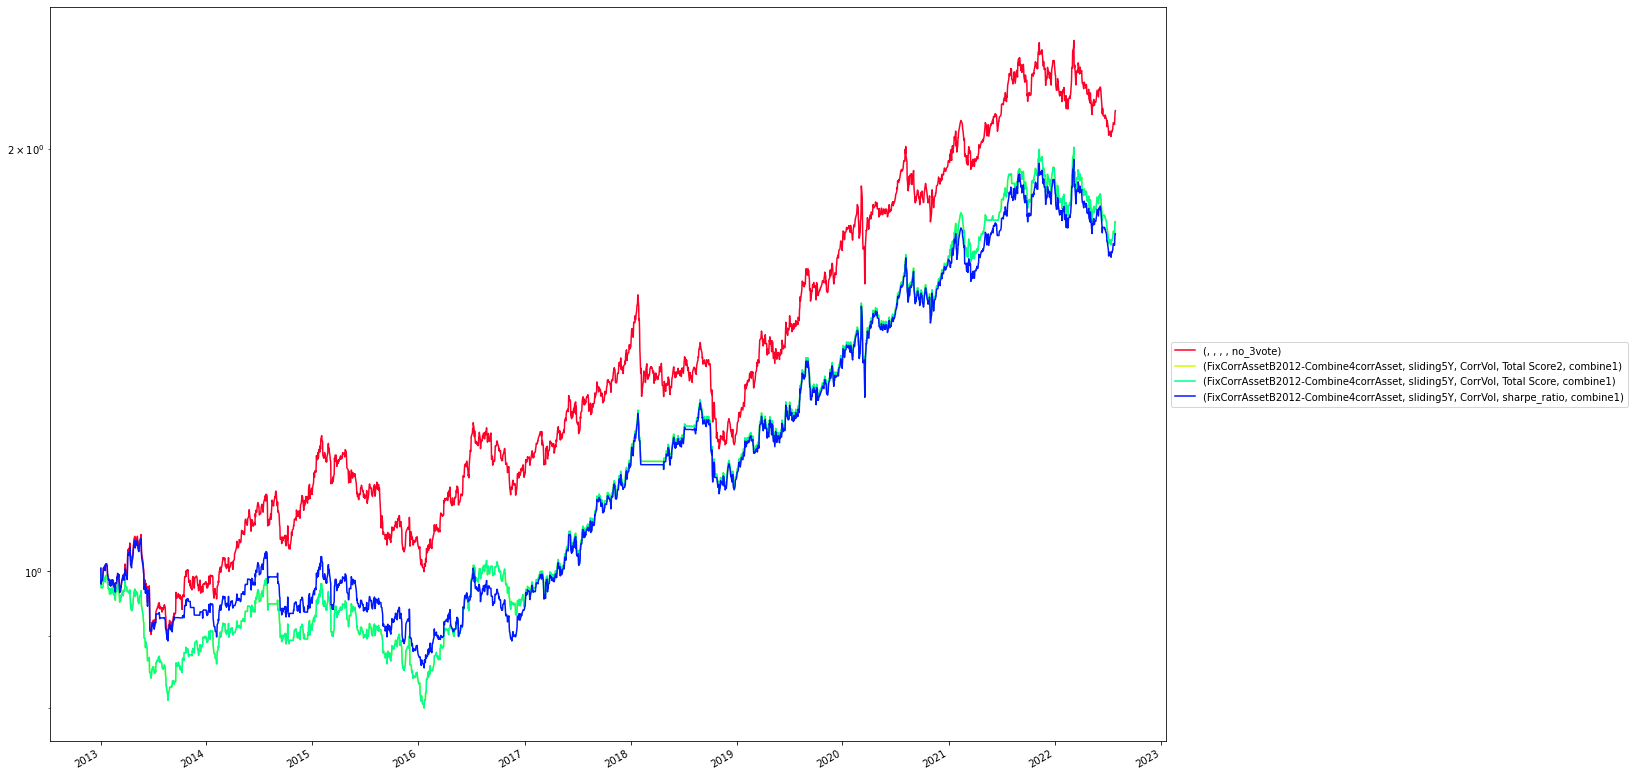

In [235]:
show_ret = pd.concat([base_case_ret, all_ret_df[show_df.index[:10]]], axis=1)
show_ret = show_ret.dropna()
show_cum_ret(show_ret[start:])
# for yy in range(show_ret.index[0].year, show_ret.index[-1].year + 1):
#     show_cum_ret(show_ret[str(yy)])

# Stage5:

### Sliding lookback window to choose 

- the assets in each correlation asset case
- the threshold
- the condition case
- the correlation asset case

In [236]:
base_folder = './result/2022/cashON_signal/result/yearly_threshold/sliding_withAsset_13ETFs_combine1Only/'
sliding_case_name = 'sliding_withAsset_13ETFs'

In [237]:
all_ret = {}
all_met = {}
for f in os.listdir(base_folder):
    try:
        case_folder = os.path.join(base_folder, f)
        
        case_type2 = f.split('_')
        if len(case_type2) > 2:
            case_type2 = [case_type2[0], "_".join(case_type2[1:])]
        print(case_type2)

        ret = pd.read_csv(os.path.join(case_folder, 'final_ret.csv'), index_col=0)
        names = ['case_metrics', 'case_combine']
        ret.columns = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in ret.columns], names=names)
        ret.index = pd.to_datetime(ret.index)
        all_ret[tuple(case_type2)] = ret
        met = pd.read_csv(os.path.join(case_folder, 'final_metrics.csv'), index_col=0)
        names = ['case_metrics', 'case_combine']
        met.index = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in met.index], names=names)
        all_met[tuple(case_type2)] = met
    except:
        print("Failed for {}".format(f))
    # break
all_ret_df = pd.concat(all_ret.values(), keys=all_ret.keys(), axis=1)
# all_met_df = pd.concat(all_met.values(), keys=all_met.keys())

['met(from2016).csv']
Failed for met(from2016).csv
['sliding1Y', 'CorrVol']
['sliding2Y', 'CorrVol']
['sliding3Y', 'CorrVol']
['sliding4Y', 'CorrVol']
['sliding5Y', 'CorrVol']
['sliding6Y', 'CorrVol']
['sliding7Y', 'CorrVol']
['sliding8Y', 'CorrVol']


In [238]:
# 13ETFs	v1	sliding1Y	2thresholds	combine2	no_3vote
idx_names = ['sliding_year', 'case_pool', 'case_metrics', 'case_combine']
all_ret_df.columns.names = idx_names
# all_met_df.index.names = idx_names
# all_ret_df_dict[sliding_case_name] = all_ret_df
all_ret_df.dropna()

sliding_year sliding1Y                                       sliding2Y  \
case_pool      CorrVol                                         CorrVol   
case_metrics           sharpe_ratio Total Score Total Score2             
case_combine  no_3vote     combine1    combine1     combine1  no_3vote   
2016-01-04   -0.005053    -0.005053   -0.005053    -0.005053 -0.005053   
2016-01-05    0.002157     0.002157    0.002157     0.002157  0.002157   
2016-01-06    0.001254     0.001254    0.001254     0.001254  0.001254   
2016-01-07   -0.015764    -0.015764   -0.015764    -0.015764 -0.015764   
2016-01-08   -0.005109    -0.005109   -0.005109    -0.005109 -0.005109   
...                ...          ...         ...          ...       ...   
2022-07-25   -0.000582    -0.000582   -0.000582    -0.000582 -0.000582   
2022-07-26   -0.002362    -0.002362   -0.002362    -0.002362 -0.002362   
2022-07-27    0.009400     0.009400    0.009400     0.009400  0.009400   
2022-07-28    0.009597     0.009597    0.009597     0.009597  0.009597   
2022-07-29    0.003906     0.003909    0.003909     0.003909  0.003906   

sliding_year                                       sliding3Y               \
case_pool                                            CorrVol                
case_metrics sharpe_ratio Total Score Total Score2           sharpe_ratio   
case_combine     combine1    combine1     combine1  no_3vote     combine1   
2016-01-04      -0.005053   -0.005053    -0.005053 -0.005053    -0.005053   
2016-01-05      -0.000190   -0.000190    -0.000190  0.002157     0.002157   
2016-01-06       0.001063    0.001063     0.001063  0.001254     0.001254   
2016-01-07      -0.000192   -0.000192    -0.000192 -0.015764    -0.015764   
2016-01-08      -0.005297   -0.005297    -0.005297 -0.005109    -0.005109   
...                   ...         ...          ...       ...          ...   
2022-07-25      -0.000582   -0.000582    -0.000582 -0.000582    -0.000582   
2022-07-26      -0.002362   -0.002362    -0.002362 -0.002362    -0.002362   
2022-07-27       0.009400    0.009400     0.009400  0.009400     0.009400   
2022-07-28       0.009597    0.009597     0.009597  0.009597     0.009597   
2022-07-29       0.003906    0.003906     0.003906  0.003906     0.003906   

sliding_year  ...   sliding6Y              sliding7Y                           \
case_pool     ...     CorrVol                CorrVol                            
case_metrics  ... Total Score           sharpe_ratio Total Score2 Total Score   
case_combine  ...    combine1  no_3vote     combine1     combine1    combine1   
2016-01-04    ...   -0.005053 -0.005053    -0.005053    -0.005053   -0.005053   
2016-01-05    ...   -0.000190  0.002157     0.002157     0.002157    0.002157   
2016-01-06    ...    0.001063  0.001254    -0.000190    -0.000190   -0.000190   
2016-01-07    ...   -0.000192 -0.015764    -0.015952    -0.015952   -0.015952   
2016-01-08    ...   -0.005297 -0.005109    -0.005109    -0.005109   -0.005109   
...           ...         ...       ...          ...          ...         ...   
2022-07-25    ...   -0.000582 -0.000582    -0.000582    -0.000582   -0.000582   
2022-07-26    ...   -0.000100 -0.002362    -0.000100    -0.000100   -0.000100   
2022-07-27    ...    0.009299  0.009400     0.009299     0.009299    0.009299   
2022-07-28    ...   -0.000101  0.009597    -0.000101    -0.000101   -0.000101   
2022-07-29    ...    0.003801  0.003906     0.003801     0.003801    0.003801   

sliding_year              sliding8Y                                     
case_pool                   CorrVol                                     
case_metrics           sharpe_ratio Total Score2 Total Score            
case_combine  no_3vote     combine1     combine1    combine1  no_3vote  
2016-01-04   -0.005053    -0.005053    -0.005053   -0.005053 -0.005053  
2016-01-05    0.002157     0.002157     0.002157    0.002157  0.002157  
2016-01-06    0.001254     0.001254    -0.000190    0.001254  0.001254  
2016-0

In [239]:
all_met_df = empy_metric(all_ret_df[start:].dropna())
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df.dropna())], axis=1)

In [240]:
all_met_df.to_csv(os.path.join(base_folder, 'met(from{}).csv'.format(start)))

In [241]:
base_case_name = 'no_3vote'
base_case_ret = all_ret_df.loc[:, all_ret_df.columns.get_level_values('case_combine') == base_case_name].iloc[:, [0]]
base_case_ret.columns = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
# display(base_case_ret)
base_case_met = all_met_df.loc[all_met_df.index.get_level_values('case_combine') == base_case_name, :].iloc[[0], :]
base_case_met.index = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
base_case_met

,,,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,case_metrics,case_combine,,,,,,,,,,,,,,,,
,,,no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.70045,94.454598,3.821084,3.543814,1.0,0.0


In [242]:
sort_by = 'sharpe_ratio'
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
show_df = pd.concat([show_df, base_case_met])
show_df.head(20)

total_return  annual_return  \
sliding_year case_pool case_metrics case_combine                                
sliding3Y    CorrVol   sharpe_ratio combine1          1.251502       0.131539   
                       Total Score2 combine1          1.133230       0.122280   
                       Total Score  combine1          1.133230       0.122280   
sliding5Y    CorrVol   Total Score2 combine1          1.213569       0.128615   
                       Total Score  combine1          1.213569       0.128615   
                       sharpe_ratio combine1          1.106307       0.120112   
sliding4Y    CorrVol   sharpe_ratio combine1          1.061920       0.116485   
                                    no_3vote          1.041942       0.114831   

                                                  sharpe_ratio  \
sliding_year case_pool case_metrics case_combine                 
sliding3Y    CorrVol   sharpe_ratio combine1          1.069896   
                       Total Score2 combine1          1.036839   
                       Total Score  combine1          1.036839   
sliding5Y    CorrVol   Total Score2 combine1          1.032507   
                       Total Score  combine1          1.032507   
                       sharpe_ratio combine1          0.975432   
sliding4Y    CorrVol   sharpe_ratio combine1          0.938796   
                                    no_3vote          0.872381   

                                                  annual_volatility  \
sliding_year case_pool case_metrics case_combine                      
sliding3Y    CorrVol   sharpe_ratio combine1               0.122558   
                       Total Score2 combine1               0.118010   
                       Total Score  combine1               0.118010   
sliding5Y    CorrVol   Total Score2 combine1               0.124757   
                       Total Score  combine1               0.124757   
                       sharpe_ratio combine1               0.124233   
sliding4Y    CorrVol   sharpe_ratio combine1               0.125836   
                                    no_3vote               0.135112   

                                                  max_drawdown  avg_drawdown  \
sliding_year case_pool case_metrics case_combine                               
sliding3Y    CorrVol   sharpe_ratio combine1         -0.229530     -0.051481   
                       Total Score2 combine1         -0.229530     -0.046634   
                       Total Score  combine1         -0.229530     -0.046634   
sliding5Y    CorrVol   Total Score2 combine1         -0.154083     -0.039176   
                       Total Score  combine1         -0.154083     -0.039176   
                       sharpe_ratio combine1         -0.154083     -0.041076   
sliding4Y    CorrVol   sharpe_ratio combine1         -0.221480     -0.056772   
                                    no_3vote         -0.222995     -0.055454   

                                                  return/maxdd  return/avgdd  \
sliding_year case_pool case_metrics case_combine                               
sliding3Y    CorrVol   sharpe_ratio combine1          0.573080      2.555083   
                       Total Score2 combine1          0.532741      2.622135   
                       Total Score  combine1          0.532741      2.622135   
sliding5Y    CorrVol   Total Score2 combine1          0.834713      3.283042   
                       Total Score  combine1          0.834713      3.283042   
                       sharpe_ratio combine1          0.779524      2.924134   
sliding4Y    CorrVol   sharpe_ratio combine1          0.525940      2.051806   
                                    no_3vote          0.514948      2.070742   

                                                  Sharpe Score  Return Score  \
sliding_year case_pool case_metrics case_combine                               
sliding3Y    CorrVol   sharpe_ratio combine1        106.989636    106.576949   
                       To

In [243]:
groupby_items = [
    'sliding_year', 'case_pool', 'case_metrics', 'case_combine',
    ['sliding_year', 'case_pool'], ['sliding_year', 'case_combine']
]

all_met_df_count = all_met_df.loc[all_met_df.index.get_level_values('case_combine') != base_case_name, :]
show_df_count = show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
base_met_single_index = base_case_met.copy()
base_met_single_index.index = [base_case_name]


for gb in groupby_items:
    print("================================================== ", gb)
    ser1 = show_df_count.groupby(gb).count().mean(axis=1)
    ser2 = all_met_df_count.groupby(gb).count().mean(axis=1)
    ser3 = ser1 / ser2
    df = pd.concat([ser1.to_frame(), ser2.to_frame(), ser3.to_frame()], axis=1)
    df.columns = ['better', 'total', 'pct']
    display(df)

    perf = all_met_df_count.groupby(gb).mean()
    perf = pd.concat([base_met_single_index, perf])
    display("average: ", perf)

    perf_std = all_met_df_count.groupby(gb).max()
    display("max: ", perf_std)

    perf_std = all_met_df_count.groupby(gb).min()
    display("min: ", perf_std)

    perf_std = all_met_df_count.groupby(gb).std()
    display("std: ", perf_std)

==================================================  sliding_year


,better,total,pct
sliding_year,,,
sliding3Y,3.0,3.0,1.000000
sliding4Y,1.0,3.0,0.333333
sliding5Y,3.0,3.0,1.000000
sliding1Y,NaN,3.0,NaN
sliding2Y,NaN,3.0,NaN
sliding6Y,NaN,3.0,NaN
sliding7Y,NaN,3.0,NaN
sliding8Y,NaN,3.0,NaN


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
sliding1Y,0.430932,0.056077,0.598597,0.099428,-0.153207,-0.048155,0.366019,1.164514,59.859727,102.803833,84.679322,95.184544,2.507336,2.266563,0.609063,0.038694
sliding2Y,0.750384,0.088982,0.741853,0.125565,-0.169911,-0.045218,0.523701,1.967851,74.185254,104.449124,83.008905,95.478190,3.304620,3.078530,0.962538,0.047158
sliding3Y,1.172654,0.125366,1.047858,0.119526,-0.229530,-0.048250,0.546187,2.599784,104.785781,106.268315,77.047010,95.175041,4.718471,4.477223,0.859819,0.027811
sliding4Y,0.937633,0.105822,0.849631,0.128198,-0.221480,-0.059456,0.477794,1.785839,84.963080,105.291079,77.852031,94.054420,3.669863,3.372584,0.960121,0.024587
sliding5Y,1.177815,0.125781,1.013482,0.124582,-0.154083,-0.039809,0.816317,3.163406,101.348160,106.289034,84.591682,96.019093,4.925895,4.726850,0.934743,0.031842
sliding6Y,0.698634,0.084018,0.709740,0.124648,-0.164277,-0.047480,0.511439,1.769547,70.974023,104.200884,83.572311,95.252025,3.147405,2.910006,0.978248,0.037485
sliding7Y,0.858861,0.098982,0.819405,0.124726,-0.191547,-0.047548,0.516753,2.082512,81.940462,104.949110,80.845341,95.245191,3.634201,3.396461,0.969184,0.046352
sliding8Y,0.382550,0.050453,0.477963,0.117311,-0.232426,-0.060713,0.219652,0.831920,47.796271,102.522671,76.757381,93.928686,1.479950,1.176384,0.830413,0.036679


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,0.430932,0.056077,0.598597,0.099428,-0.153207,-0.048155,0.366019,1.164514,59.859727,102.803833,84.679322,95.184544,2.507336,2.266563,0.609063,0.038694
sliding2Y,0.750384,0.088982,0.741853,0.125565,-0.169911,-0.045218,0.523701,1.967851,74.185254,104.449124,83.008905,95.478190,3.304620,3.078530,0.962538,0.047158
sliding3Y,1.251502,0.131539,1.069896,0.122558,-0.229530,-0.046634,0.573080,2.622135,106.989636,106.576949,77.047010,95.336626,4.859527,4.602121,0.904532,0.030230
sliding4Y,1.061920,0.116485,0.938796,0.129378,-0.221480,-0.056772,0.525940,2.051806,93.879635,105.824248,77.852031,94.322809,4.169008,3.885149,0.964350,0.037485
sliding5Y,1.213569,0.128615,1.032507,0.124757,-0.154083,-0.039176,0.834713,3.283042,103.250653,106.430761,84.591682,96.082437,5.035193,4.839315,0.934743,0.035067
sliding6Y,0.698634,0.084018,0.709740,0.124648,-0.164277,-0.047480,0.511439,1.769547,70.974023,104.200884,83.572311,95.252025,3.147405,2.910006,0.978248,0.037485
sliding7Y,0.878717,0.100778,0.834763,0.125550,-0.191547,-0.047195,0.526128,2.135338,83.476343,105.038900,80.845341,95.280465,3.719974,3.483997,0.972810,0.049577
sliding8Y,0.460310,0.059350,0.547538,0.118053,-0.212380,-0.054221,0.279450,0.938361,54.753827,102.967486,78.761956,94.577876,1.972538,1.656296,0.839879,0.039903


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,0.430932,0.056077,0.598597,0.099428,-0.153207,-0.048155,0.366019,1.164514,59.859727,102.803833,84.679322,95.184544,2.507336,2.266563,0.609063,0.038694
sliding2Y,0.750384,0.088982,0.741853,0.125565,-0.169911,-0.045218,0.523701,1.967851,74.185254,104.449124,83.008905,95.478190,3.304620,3.078530,0.962538,0.047158
sliding3Y,1.133230,0.122280,1.036839,0.118010,-0.229530,-0.051481,0.532741,2.555083,103.683854,106.113997,77.047010,94.851871,4.647943,4.414774,0.837462,0.022975
sliding4Y,0.875490,0.100490,0.805048,0.125836,-0.221480,-0.060798,0.453721,1.652856,80.504803,105.024494,77.852031,93.920226,3.420291,3.116302,0.951662,0.018138
sliding5Y,1.106307,0.120112,0.975432,0.124233,-0.154083,-0.041076,0.779524,2.924134,97.543175,106.005580,84.591682,95.892404,4.707301,4.501921,0.934743,0.030230
sliding6Y,0.698634,0.084018,0.709740,0.124648,-0.164277,-0.047480,0.511439,1.769547,70.974023,104.200884,83.572311,95.252025,3.147405,2.910006,0.978248,0.037485
sliding7Y,0.819147,0.095391,0.788687,0.124314,-0.191547,-0.048254,0.498002,1.976860,78.868701,104.769529,80.845341,95.174642,3.462655,3.221387,0.967372,0.039903
sliding8Y,0.336705,0.045180,0.438529,0.116184,-0.242449,-0.064670,0.186346,0.724155,43.852862,102.258976,75.755093,93.533012,1.206295,0.935189,0.823565,0.033857


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
sliding1Y,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding2Y,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding3Y,0.068285,0.005346,0.019086,0.002626,1.922963e-16,0.002799,0.023290,0.038712,1.908594,0.267285,1.740467e-14,0.279873,0.122158,0.108165,0.038723,0.004189
sliding4Y,0.107636,0.009235,0.077220,0.002045,0.000000e+00,0.002324,0.041696,0.230334,7.721963,0.461738,0.000000e+00,0.232431,0.432272,0.443894,0.007326,0.011170
sliding5Y,0.061928,0.004910,0.032952,0.000302,1.520235e-16,0.001097,0.031863,0.207216,3.295214,0.245479,2.009718e-14,0.109716,0.189309,0.194794,0.000000,0.002793
sliding6Y,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding7Y,0.034393,0.003110,0.026602,0.000714,0.000000e+00,0.000611,0.016239,0.091497,2.660223,0.155522,0.000000e+00,0.061097,0.148563,0.151618,0.003140,0.005585
sliding8Y,0.067701,0.007749,0.060433,0.000992,1.736013e-02,0.005667,0.051899,0.107109,6.043308,0.387428,1.736013e+00,0.566690,0.427470,0.415618,0.008466,0.003043


==================================================  case_pool


,better,total,pct
case_pool,,,
CorrVol,7.0,24.0,0.291667


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
CorrVol,0.801183,0.091935,0.782316,0.120498,-0.189558,-0.049579,0.497233,1.920672,78.231595,104.596756,81.044248,95.042149,3.423468,3.175575,0.888016,0.036326


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_pool,,,,,,,,,,,,,,,,
CorrVol,1.251502,0.131539,1.069896,0.129378,-0.153207,-0.039176,0.834713,3.283042,106.989636,106.576949,84.679322,96.082437,5.035193,4.839315,0.978248,0.049577


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_pool,,,,,,,,,,,,,,,,
CorrVol,0.336705,0.04518,0.438529,0.099428,-0.242449,-0.06467,0.186346,0.724155,43.852862,102.258976,75.755093,93.533012,1.206295,0.935189,0.609063,0.018138


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_pool,,,,,,,,,,,,,,,,
CorrVol,0.28993,0.02732,0.188008,0.008848,0.032832,0.007037,0.163245,0.714179,18.800789,1.365977,3.283221,0.703656,1.085955,1.106481,0.120154,0.008716


==================================================  case_metrics


,better,total,pct
case_metrics,,,
Total Score,2.0,8.0,0.250
Total Score2,2.0,8.0,0.250
sharpe_ratio,3.0,8.0,0.375


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
Total Score,0.791449,0.091009,0.775896,0.120475,-0.190810,-0.049916,0.492702,1.914930,77.589597,104.550443,80.918962,95.008440,3.380472,3.130894,0.885196,0.035973
Total Score2,0.789708,0.090802,0.774734,0.120286,-0.190810,-0.048610,0.491851,1.928566,77.473440,104.540121,80.918962,95.139049,3.373632,3.130585,0.884668,0.036427
sharpe_ratio,0.822392,0.093994,0.796317,0.120734,-0.187052,-0.050210,0.507144,1.918520,79.631747,104.699704,81.294820,94.978957,3.516299,3.265247,0.894184,0.036578


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,1.213569,0.128615,1.036839,0.129378,-0.153207,-0.039176,0.834713,3.283042,103.683854,106.430761,84.679322,96.082437,5.035193,4.839315,0.978248,0.049577
Total Score2,1.213569,0.128615,1.036839,0.129378,-0.153207,-0.039176,0.834713,3.283042,103.683854,106.430761,84.679322,96.082437,5.035193,4.839315,0.978248,0.049577
sharpe_ratio,1.251502,0.131539,1.069896,0.125836,-0.153207,-0.041076,0.779524,2.924134,106.989636,106.576949,84.679322,95.892404,4.859527,4.602121,0.978248,0.047158


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,0.350637,0.046831,0.447821,0.099428,-0.242449,-0.064670,0.193158,0.724155,44.782122,102.341551,75.755093,93.533012,1.261016,0.937666,0.609063,0.018138
Total Score2,0.336705,0.045180,0.438529,0.099428,-0.242449,-0.060798,0.186346,0.833244,43.852862,102.258976,75.755093,93.920226,1.206295,0.935189,0.609063,0.018138
sharpe_ratio,0.430932,0.056077,0.547538,0.099428,-0.229530,-0.063248,0.279450,0.938361,54.753827,102.803833,77.047010,93.675170,1.972538,1.656296,0.609063,0.022975


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,0.303378,0.028791,0.201018,0.009354,0.035878,0.008458,0.180594,0.801261,20.101835,1.439540,3.587803,0.845770,1.181764,1.213071,0.126455,0.010029
Total Score2,0.306296,0.029156,0.203200,0.009433,0.035878,0.006414,0.182216,0.778712,20.319994,1.457820,3.587803,0.641350,1.195858,1.213711,0.126738,0.010126
sharpe_ratio,0.299279,0.027677,0.184674,0.008981,0.030929,0.006954,0.146886,0.653726,18.467431,1.383853,3.092925,0.695422,1.016559,1.031639,0.123762,0.006802


==================================================  case_combine


,better,total,pct
case_combine,,,
combine1,7.0,24.0,0.291667


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
combine1,0.801183,0.091935,0.782316,0.120498,-0.189558,-0.049579,0.497233,1.920672,78.231595,104.596756,81.044248,95.042149,3.423468,3.175575,0.888016,0.036326


'max: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_combine,,,,,,,,,,,,,,,,
combine1,1.251502,0.131539,1.069896,0.129378,-0.153207,-0.039176,0.834713,3.283042,106.989636,106.576949,84.679322,96.082437,5.035193,4.839315,0.978248,0.049577


'min: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_combine,,,,,,,,,,,,,,,,
combine1,0.336705,0.04518,0.438529,0.099428,-0.242449,-0.06467,0.186346,0.724155,43.852862,102.258976,75.755093,93.533012,1.206295,0.935189,0.609063,0.018138


'std: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_combine,,,,,,,,,,,,,,,,
combine1,0.28993,0.02732,0.188008,0.008848,0.032832,0.007037,0.163245,0.714179,18.800789,1.365977,3.283221,0.703656,1.085955,1.106481,0.120154,0.008716


==================================================  ['sliding_year', 'case_pool']


,,better,total,pct
sliding_year,case_pool,,,
sliding3Y,CorrVol,3.0,3.0,1.000000
sliding4Y,CorrVol,1.0,3.0,0.333333
sliding5Y,CorrVol,3.0,3.0,1.000000
sliding1Y,CorrVol,NaN,3.0,NaN
sliding2Y,CorrVol,NaN,3.0,NaN
sliding6Y,CorrVol,NaN,3.0,NaN
sliding7Y,CorrVol,NaN,3.0,NaN
sliding8Y,CorrVol,NaN,3.0,NaN


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
"(sliding1Y, CorrVol)",0.430932,0.056077,0.598597,0.099428,-0.153207,-0.048155,0.366019,1.164514,59.859727,102.803833,84.679322,95.184544,2.507336,2.266563,0.609063,0.038694
"(sliding2Y, CorrVol)",0.750384,0.088982,0.741853,0.125565,-0.169911,-0.045218,0.523701,1.967851,74.185254,104.449124,83.008905,95.478190,3.304620,3.078530,0.962538,0.047158
"(sliding3Y, CorrVol)",1.172654,0.125366,1.047858,0.119526,-0.229530,-0.048250,0.546187,2.599784,104.785781,106.268315,77.047010,95.175041,4.718471,4.477223,0.859819,0.027811
"(sliding4Y, CorrVol)",0.937633,0.105822,0.849631,0.128198,-0.221480,-0.059456,0.477794,1.785839,84.963080,105.291079,77.852031,94.054420,3.669863,3.372584,0.960121,0.024587
"(sliding5Y, CorrVol)",1.177815,0.125781,1.013482,0.124582,-0.154083,-0.039809,0.816317,3.163406,101.348160,106.289034,84.591682,96.019093,4.925895,4.726850,0.934743,0.031842
"(sliding6Y, CorrVol)",0.698634,0.084018,0.709740,0.124648,-0.164277,-0.047480,0.511439,1.769547,70.974023,104.200884,83.572311,95.252025,3.147405,2.910006,0.978248,0.037485
"(sliding7Y, CorrVol)",0.858861,0.098982,0.819405,0.124726,-0.191547,-0.047548,0.516753,2.082512,81.940462,104.949110,80.845341,95.245191,3.634201,3.396461,0.969184,0.046352
"(sliding8Y, CorrVol)",0.382550,0.050453,0.477963,0.117311,-0.232426,-0.060713,0.219652,0.831920,47.796271,102.522671,76.757381,93.928686,1.479950,1.176384,0.830413,0.036679


'max: '

,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,,,,,,,,,,,,,,,,
sliding1Y,CorrVol,0.430932,0.056077,0.598597,0.099428,-0.153207,-0.048155,0.366019,1.164514,59.859727,102.803833,84.679322,95.184544,2.507336,2.266563,0.609063,0.038694
sliding2Y,CorrVol,0.750384,0.088982,0.741853,0.125565,-0.169911,-0.045218,0.523701,1.967851,74.185254,104.449124,83.008905,95.478190,3.304620,3.078530,0.962538,0.047158
sliding3Y,CorrVol,1.251502,0.131539,1.069896,0.122558,-0.229530,-0.046634,0.573080,2.622135,106.989636,106.576949,77.047010,95.336626,4.859527,4.602121,0.904532,0.030230
sliding4Y,CorrVol,1.061920,0.116485,0.938796,0.129378,-0.221480,-0.056772,0.525940,2.051806,93.879635,105.824248,77.852031,94.322809,4.169008,3.885149,0.964350,0.037485
sliding5Y,CorrVol,1.213569,0.128615,1.032507,0.124757,-0.154083,-0.039176,0.834713,3.283042,103.250653,106.430761,84.591682,96.082437,5.035193,4.839315,0.934743,0.035067
sliding6Y,CorrVol,0.698634,0.084018,0.709740,0.124648,-0.164277,-0.047480,0.511439,1.769547,70.974023,104.200884,83.572311,95.252025,3.147405,2.910006,0.978248,0.037485
sliding7Y,CorrVol,0.878717,0.100778,0.834763,0.125550,-0.191547,-0.047195,0.526128,2.135338,83.476343,105.038900,80.845341,95.280465,3.719974,3.483997,0.972810,0.049577
sliding8Y,CorrVol,0.460310,0.059350,0.547538,0.118053,-0.212380,-0.054221,0.279450,0.938361,54.753827,102.967486,78.761956,94.577876,1.972538,1.656296,0.839879,0.039903


'min: '

,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,,,,,,,,,,,,,,,,
sliding1Y,CorrVol,0.430932,0.056077,0.598597,0.099428,-0.153207,-0.048155,0.366019,1.164514,59.859727,102.803833,84.679322,95.184544,2.507336,2.266563,0.609063,0.038694
sliding2Y,CorrVol,0.750384,0.088982,0.741853,0.125565,-0.169911,-0.045218,0.523701,1.967851,74.185254,104.449124,83.008905,95.478190,3.304620,3.078530,0.962538,0.047158
sliding3Y,CorrVol,1.133230,0.122280,1.036839,0.118010,-0.229530,-0.051481,0.532741,2.555083,103.683854,106.113997,77.047010,94.851871,4.647943,4.414774,0.837462,0.022975
sliding4Y,CorrVol,0.875490,0.100490,0.805048,0.125836,-0.221480,-0.060798,0.453721,1.652856,80.504803,105.024494,77.852031,93.920226,3.420291,3.116302,0.951662,0.018138
sliding5Y,CorrVol,1.106307,0.120112,0.975432,0.124233,-0.154083,-0.041076,0.779524,2.924134,97.543175,106.005580,84.591682,95.892404,4.707301,4.501921,0.934743,0.030230
sliding6Y,CorrVol,0.698634,0.084018,0.709740,0.124648,-0.164277,-0.047480,0.511439,1.769547,70.974023,104.200884,83.572311,95.252025,3.147405,2.910006,0.978248,0.037485
sliding7Y,CorrVol,0.819147,0.095391,0.788687,0.124314,-0.191547,-0.048254,0.498002,1.976860,78.868701,104.769529,80.845341,95.174642,3.462655,3.221387,0.967372,0.039903
sliding8Y,CorrVol,0.336705,0.045180,0.438529,0.116184,-0.242449,-0.064670,0.186346,0.724155,43.852862,102.258976,75.755093,93.533012,1.206295,0.935189,0.823565,0.033857


'std: '

,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,,,,,,,,,,,,,,,,
sliding1Y,CorrVol,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding2Y,CorrVol,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding3Y,CorrVol,0.068285,0.005346,0.019086,0.002626,1.922963e-16,0.002799,0.023290,0.038712,1.908594,0.267285,1.740467e-14,0.279873,0.122158,0.108165,0.038723,0.004189
sliding4Y,CorrVol,0.107636,0.009235,0.077220,0.002045,0.000000e+00,0.002324,0.041696,0.230334,7.721963,0.461738,0.000000e+00,0.232431,0.432272,0.443894,0.007326,0.011170
sliding5Y,CorrVol,0.061928,0.004910,0.032952,0.000302,1.520235e-16,0.001097,0.031863,0.207216,3.295214,0.245479,2.009718e-14,0.109716,0.189309,0.194794,0.000000,0.002793
sliding6Y,CorrVol,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding7Y,CorrVol,0.034393,0.003110,0.026602,0.000714,0.000000e+00,0.000611,0.016239,0.091497,2.660223,0.155522,0.000000e+00,0.061097,0.148563,0.151618,0.003140,0.005585
sliding8Y,CorrVol,0.067701,0.007749,0.060433,0.000992,1.736013e-02,0.005667,0.051899,0.107109,6.043308,0.387428,1.736013e+00,0.566690,0.427470,0.415618,0.008466,0.003043


==================================================  ['sliding_year', 'case_combine']


,,better,total,pct
sliding_year,case_combine,,,
sliding3Y,combine1,3.0,3.0,1.000000
sliding4Y,combine1,1.0,3.0,0.333333
sliding5Y,combine1,3.0,3.0,1.000000
sliding1Y,combine1,NaN,3.0,NaN
sliding2Y,combine1,NaN,3.0,NaN
sliding6Y,combine1,NaN,3.0,NaN
sliding7Y,combine1,NaN,3.0,NaN
sliding8Y,combine1,NaN,3.0,NaN


'average: '

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.041942,0.114831,0.872381,0.135112,-0.222995,-0.055454,0.514948,2.070742,87.238133,105.741549,77.700450,94.454598,3.821084,3.543814,1.000000,0.000000
"(sliding1Y, combine1)",0.430932,0.056077,0.598597,0.099428,-0.153207,-0.048155,0.366019,1.164514,59.859727,102.803833,84.679322,95.184544,2.507336,2.266563,0.609063,0.038694
"(sliding2Y, combine1)",0.750384,0.088982,0.741853,0.125565,-0.169911,-0.045218,0.523701,1.967851,74.185254,104.449124,83.008905,95.478190,3.304620,3.078530,0.962538,0.047158
"(sliding3Y, combine1)",1.172654,0.125366,1.047858,0.119526,-0.229530,-0.048250,0.546187,2.599784,104.785781,106.268315,77.047010,95.175041,4.718471,4.477223,0.859819,0.027811
"(sliding4Y, combine1)",0.937633,0.105822,0.849631,0.128198,-0.221480,-0.059456,0.477794,1.785839,84.963080,105.291079,77.852031,94.054420,3.669863,3.372584,0.960121,0.024587
"(sliding5Y, combine1)",1.177815,0.125781,1.013482,0.124582,-0.154083,-0.039809,0.816317,3.163406,101.348160,106.289034,84.591682,96.019093,4.925895,4.726850,0.934743,0.031842
"(sliding6Y, combine1)",0.698634,0.084018,0.709740,0.124648,-0.164277,-0.047480,0.511439,1.769547,70.974023,104.200884,83.572311,95.252025,3.147405,2.910006,0.978248,0.037485
"(sliding7Y, combine1)",0.858861,0.098982,0.819405,0.124726,-0.191547,-0.047548,0.516753,2.082512,81.940462,104.949110,80.845341,95.245191,3.634201,3.396461,0.969184,0.046352
"(sliding8Y, combine1)",0.382550,0.050453,0.477963,0.117311,-0.232426,-0.060713,0.219652,0.831920,47.796271,102.522671,76.757381,93.928686,1.479950,1.176384,0.830413,0.036679


'max: '

,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_combine,,,,,,,,,,,,,,,,
sliding1Y,combine1,0.430932,0.056077,0.598597,0.099428,-0.153207,-0.048155,0.366019,1.164514,59.859727,102.803833,84.679322,95.184544,2.507336,2.266563,0.609063,0.038694
sliding2Y,combine1,0.750384,0.088982,0.741853,0.125565,-0.169911,-0.045218,0.523701,1.967851,74.185254,104.449124,83.008905,95.478190,3.304620,3.078530,0.962538,0.047158
sliding3Y,combine1,1.251502,0.131539,1.069896,0.122558,-0.229530,-0.046634,0.573080,2.622135,106.989636,106.576949,77.047010,95.336626,4.859527,4.602121,0.904532,0.030230
sliding4Y,combine1,1.061920,0.116485,0.938796,0.129378,-0.221480,-0.056772,0.525940,2.051806,93.879635,105.824248,77.852031,94.322809,4.169008,3.885149,0.964350,0.037485
sliding5Y,combine1,1.213569,0.128615,1.032507,0.124757,-0.154083,-0.039176,0.834713,3.283042,103.250653,106.430761,84.591682,96.082437,5.035193,4.839315,0.934743,0.035067
sliding6Y,combine1,0.698634,0.084018,0.709740,0.124648,-0.164277,-0.047480,0.511439,1.769547,70.974023,104.200884,83.572311,95.252025,3.147405,2.910006,0.978248,0.037485
sliding7Y,combine1,0.878717,0.100778,0.834763,0.125550,-0.191547,-0.047195,0.526128,2.135338,83.476343,105.038900,80.845341,95.280465,3.719974,3.483997,0.972810,0.049577
sliding8Y,combine1,0.460310,0.059350,0.547538,0.118053,-0.212380,-0.054221,0.279450,0.938361,54.753827,102.967486,78.761956,94.577876,1.972538,1.656296,0.839879,0.039903


'min: '

,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_combine,,,,,,,,,,,,,,,,
sliding1Y,combine1,0.430932,0.056077,0.598597,0.099428,-0.153207,-0.048155,0.366019,1.164514,59.859727,102.803833,84.679322,95.184544,2.507336,2.266563,0.609063,0.038694
sliding2Y,combine1,0.750384,0.088982,0.741853,0.125565,-0.169911,-0.045218,0.523701,1.967851,74.185254,104.449124,83.008905,95.478190,3.304620,3.078530,0.962538,0.047158
sliding3Y,combine1,1.133230,0.122280,1.036839,0.118010,-0.229530,-0.051481,0.532741,2.555083,103.683854,106.113997,77.047010,94.851871,4.647943,4.414774,0.837462,0.022975
sliding4Y,combine1,0.875490,0.100490,0.805048,0.125836,-0.221480,-0.060798,0.453721,1.652856,80.504803,105.024494,77.852031,93.920226,3.420291,3.116302,0.951662,0.018138
sliding5Y,combine1,1.106307,0.120112,0.975432,0.124233,-0.154083,-0.041076,0.779524,2.924134,97.543175,106.005580,84.591682,95.892404,4.707301,4.501921,0.934743,0.030230
sliding6Y,combine1,0.698634,0.084018,0.709740,0.124648,-0.164277,-0.047480,0.511439,1.769547,70.974023,104.200884,83.572311,95.252025,3.147405,2.910006,0.978248,0.037485
sliding7Y,combine1,0.819147,0.095391,0.788687,0.124314,-0.191547,-0.048254,0.498002,1.976860,78.868701,104.769529,80.845341,95.174642,3.462655,3.221387,0.967372,0.039903
sliding8Y,combine1,0.336705,0.045180,0.438529,0.116184,-0.242449,-0.064670,0.186346,0.724155,43.852862,102.258976,75.755093,93.533012,1.206295,0.935189,0.823565,0.033857


'std: '

,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_combine,,,,,,,,,,,,,,,,
sliding1Y,combine1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding2Y,combine1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding3Y,combine1,0.068285,0.005346,0.019086,0.002626,1.922963e-16,0.002799,0.023290,0.038712,1.908594,0.267285,1.740467e-14,0.279873,0.122158,0.108165,0.038723,0.004189
sliding4Y,combine1,0.107636,0.009235,0.077220,0.002045,0.000000e+00,0.002324,0.041696,0.230334,7.721963,0.461738,0.000000e+00,0.232431,0.432272,0.443894,0.007326,0.011170
sliding5Y,combine1,0.061928,0.004910,0.032952,0.000302,1.520235e-16,0.001097,0.031863,0.207216,3.295214,0.245479,2.009718e-14,0.109716,0.189309,0.194794,0.000000,0.002793
sliding6Y,combine1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
sliding7Y,combine1,0.034393,0.003110,0.026602,0.000714,0.000000e+00,0.000611,0.016239,0.091497,2.660223,0.155522,0.000000e+00,0.061097,0.148563,0.151618,0.003140,0.005585
sliding8Y,combine1,0.067701,0.007749,0.060433,0.000992,1.736013e-02,0.005667,0.051899,0.107109,6.043308,0.387428,1.736013e+00,0.566690,0.427470,0.415618,0.008466,0.003043


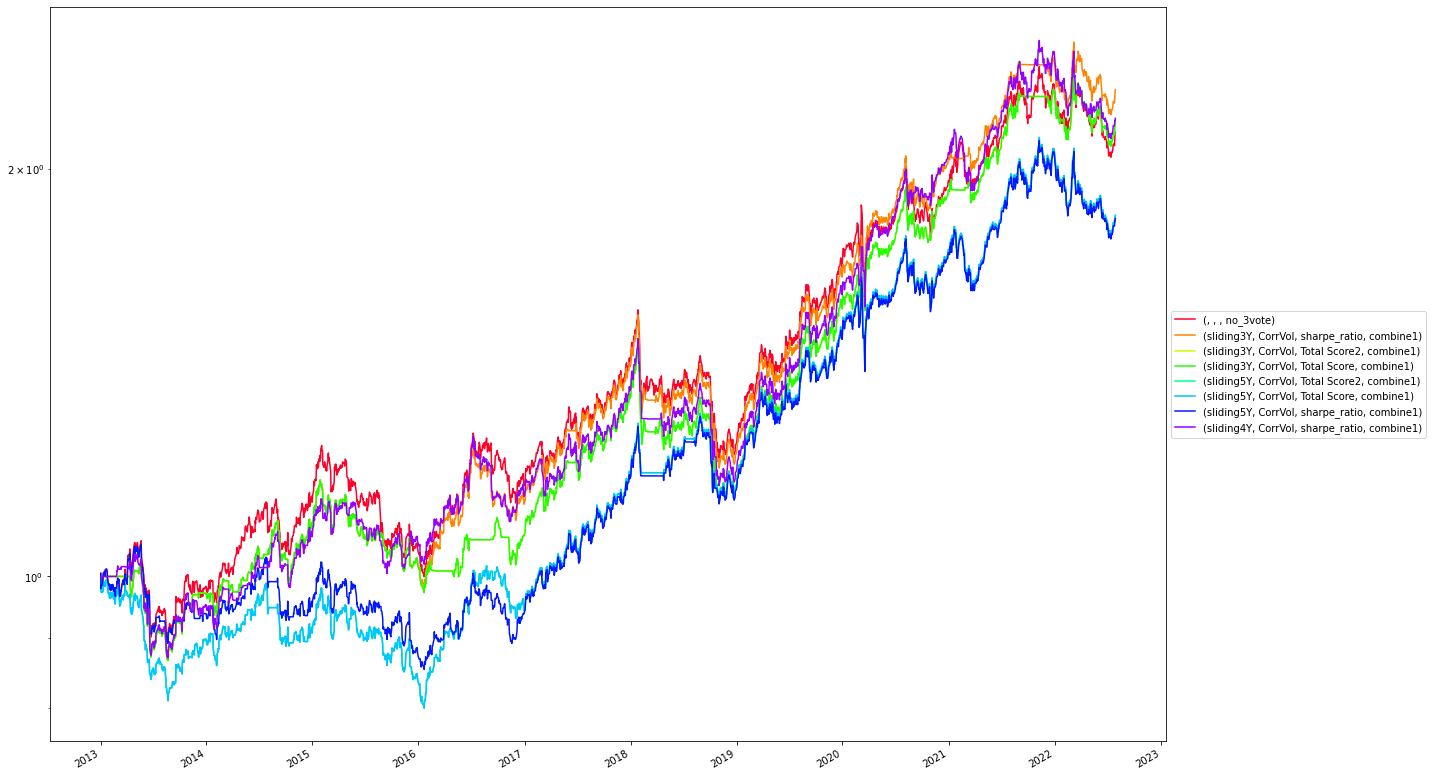

In [244]:
show_ret = pd.concat([base_case_ret, all_ret_df[show_df.index[:10]]], axis=1)
show_ret = show_ret.dropna()
show_cum_ret(show_ret[start:])

# Stage6
Sliding lookback window to choose 
- the assets in each correlation asset case
- the threshold
- the condition case
- the correlation asset case
- the sliding wondow (include 3-5 years)

In [245]:
base_folder = './result/2022/cashON_signal/result/combine_all/withAssetSliding_13ETFs_combine1Only'
start = '2013'

In [246]:
all_ret = {}
all_met = {}
if True:
    case_folder = base_folder
    for f in os.listdir(case_folder):
        try:
            case_type2 = f.split('_')
            if len(case_type2) > 2:
                case_type2 = [case_type2[0], "_".join(case_type2[1:])]
            # case_type2 = [sliding_case_name] + case_type2
            # if len(case_type2) > 2:
            #     case_type2 = [case_type2[0], "_".join(case_type2[1:])]
            print(case_type2)

            ret = pd.read_csv(os.path.join(case_folder, f, 'final_ret.csv'), index_col=0)
            names = ['case_metrics', 'case_combine']
            ret.columns = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in ret.columns], names=names)
            ret.index = pd.to_datetime(ret.index)
            all_ret[tuple(case_type2)] = ret
            met = pd.read_csv(os.path.join(case_folder, f, 'final_metrics.csv'), index_col=0)
            names = ['case_metrics', 'case_combine']
            met.index = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in met.index], names=names)
            all_met[tuple(case_type2)] = met
        except Exception as e:
            print("Failed for {}".format(f))
            print(e)
    # break
all_ret_df = pd.concat(all_ret.values(), keys=all_ret.keys(), axis=1)

['met(from2016).csv']
Failed for met(from2016).csv
[Errno 2] No such file or directory: './result/2022/cashON_signal/result/combine_all/withAssetSliding_13ETFs_combine1Only\\met(from2016).csv\\final_ret.csv'
['performance1YExclude1&2Y', 'CorrVol']
['performance1YInclude3-8Y', 'CorrVol']
['performance1YInclude5-8Y', 'CorrVol']
['performanceSlidingYearExclude1&2Y', 'CorrVol']
['performanceSlidingYearInclude3-8Y', 'CorrVol']
['performanceSlidingYearInclude5-8Y', 'CorrVol']


In [247]:
# 13ETFs	v1	sliding1Y	2thresholds	combine2	no_3vote
idx_names = ['sliding_year', 'case_pool', 'case_metrics', 'case_combine']
all_ret_df.columns.names = idx_names

In [248]:
all_met_df = empy_metric(all_ret_df[start:].dropna())
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df[start:].dropna())], axis=1)
# all_met_df_dict[sliding_case_name] = all_met_df

In [249]:
all_met_df.to_csv(os.path.join(base_folder, 'met(from{}).csv'.format(start)))

In [250]:
base_case_name = 'no_3vote'
base_case_ret = all_ret_df.loc[:, all_ret_df.columns.get_level_values('case_combine') == base_case_name].iloc[:, [0]]
base_case_ret.columns = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
# display(base_case_ret)
base_case_met = all_met_df.loc[all_met_df.index.get_level_values('case_combine') == base_case_name, :].iloc[[0], :]
base_case_met.index = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
base_case_met

,,,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,case_metrics,case_combine,,,,,,,,,,,,,,,,
,,,no_3vote,1.129764,0.082225,0.65875,0.133536,-0.222995,-0.063756,0.368729,1.289684,65.874973,104.111245,77.70045,93.624417,2.589896,2.271117,1.0,0.0


In [251]:
sort_by = 'sharpe_ratio'
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
show_df = pd.concat([base_case_met, show_df])
show_df.head(20)

total_return  \
sliding_year                      case_pool case_metrics case_combine                 
                                                         no_3vote          1.129764   
performanceSlidingYearExclude1&2Y CorrVol   Total Score2 combine1          1.325300   
                                            Total Score  combine1          1.325300   
                                            sharpe_ratio combine1          1.212623   
performanceSlidingYearInclude3-8Y CorrVol   sharpe_ratio combine1          1.212623   
                                            Total Score  combine1          1.212623   
                                            Total Score2 combine1          1.212623   
performance1YInclude3-8Y          CorrVol   Total Score  combine1          0.958563   
                                            Total Score2 combine1          0.958563   

                                                                       annual_return  \
sliding_year                      case_pool case_metrics case_combine                  
                                                         no_3vote           0.082225   
performanceSlidingYearExclude1&2Y CorrVol   Total Score2 combine1           0.092206   
                                            Total Score  combine1           0.092206   
                                            sharpe_ratio combine1           0.086551   
performanceSlidingYearInclude3-8Y CorrVol   sharpe_ratio combine1           0.086551   
                                            Total Score  combine1           0.086551   
                                            Total Score2 combine1           0.086551   
performance1YInclude3-8Y          CorrVol   Total Score  combine1           0.072787   
                                            Total Score2 combine1           0.072787   

                                                                       sharpe_ratio  \
sliding_year                      case_pool case_metrics case_combine                 
                                                         no_3vote          0.658750   
performanceSlidingYearExclude1&2Y CorrVol   Total Score2 combine1          0.796891   
                                            Total Score  combine1          0.796891   
                                            sharpe_ratio combine1          0.755527   
performanceSlidingYearInclude3-8Y CorrVol   sharpe_ratio combine1          0.755527   
                                            Total Score  combine1          0.755527   
                                            Total Score2 combine1          0.755527   
performance1YInclude3-8Y          CorrVol   Total Score  combine1          0.667041   
                                            Total Score2 combine1          0.667041   

                                                                       annual_volatility  \
sliding_year                      case_pool case_metrics case_combine                      
                                                         no_3vote               0.133536   
performanceSlidingYearExclude1&2Y CorrVol   Total Score2 combine1               0.119703   
                                            Total Score  combine1               0.119703   
                                            sharpe_ratio combine1               0.119323   
performanceSlidingYearInclude3-8Y CorrVol   sharpe_ratio combine1               0.119323   
                                            Total Score  combine1               0.119323   
                                            Total Score2 combine1               0.119323   
performance1YInclude3-8Y          CorrVol   Total Score  combine1               0.115335   
                                            Total Score2 combine1               0.115335   

                                                                       max_drawdown  \
sliding_year                      case_pool case_metrics case_combine                 

In [252]:
groupby_items = [
    'sliding_year', 'case_pool', 'case_metrics', 'case_combine',
    ['sliding_year', 'case_pool'], ['sliding_year', 'case_combine']
]

all_met_df_count = all_met_df.loc[all_met_df.index.get_level_values('case_combine') != base_case_name, :]
show_df_count = show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
base_met_single_index = base_case_met.copy()
base_met_single_index.index = [base_case_name]


for gb in groupby_items:
    print("================================================== ", gb)
    ser1 = show_df_count.groupby(gb).count().mean(axis=1)
    ser2 = all_met_df_count.groupby(gb).count().mean(axis=1)
    ser3 = ser1 / ser2
    df = pd.concat([ser1.to_frame(), ser2.to_frame(), ser3.to_frame()], axis=1)
    df.columns = ['better', 'total', 'pct']
    display(df)

    perf = all_met_df_count.groupby(gb).mean()
    perf = pd.concat([base_met_single_index, perf])
    display(perf)

    perf_std = all_met_df_count.groupby(gb).std()
    display(perf_std)

==================================================  sliding_year


,better,total,pct
sliding_year,,,
performance1YInclude3-8Y,2.0,3.0,0.666667
performanceSlidingYearExclude1&2Y,3.0,3.0,1.000000
performanceSlidingYearInclude3-8Y,3.0,3.0,1.000000
performance1YExclude1&2Y,NaN,3.0,NaN
performance1YInclude5-8Y,NaN,3.0,NaN
performanceSlidingYearInclude5-8Y,NaN,3.0,NaN


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.082225,0.658750,0.133536,-0.222995,-0.063756,0.368729,1.289684,65.874973,104.111245,77.700450,93.624417,2.589896,2.271117,1.000000,0.000000
performance1YExclude1&2Y,0.734580,0.059256,0.557140,0.115285,-0.179205,-0.053107,0.330660,1.115772,55.714019,102.962787,82.079538,94.689259,2.185956,1.920419,0.872667,0.082988
performance1YInclude3-8Y,0.924850,0.070811,0.649491,0.115690,-0.162602,-0.049432,0.435341,1.432959,64.949122,103.540550,83.739756,95.056827,2.788499,2.541340,0.858980,0.072752
performance1YInclude5-8Y,0.757133,0.060687,0.570047,0.114990,-0.162173,-0.048703,0.374211,1.246064,57.004698,103.034347,83.782716,95.129710,2.342805,2.099291,0.844878,0.065975
performanceSlidingYearExclude1&2Y,1.287741,0.090321,0.783103,0.119576,-0.221480,-0.056054,0.407808,1.614124,78.310290,104.516062,77.852031,94.394606,3.259722,2.979453,0.883866,0.038036
performanceSlidingYearInclude3-8Y,1.212623,0.086551,0.755527,0.119323,-0.221480,-0.058419,0.390785,1.481553,75.552743,104.327542,77.852031,94.158098,3.102993,2.810898,0.883866,0.040249
performanceSlidingYearInclude5-8Y,0.531576,0.045543,0.427520,0.121451,-0.191547,-0.071058,0.237765,0.640696,42.752016,102.277158,80.845341,92.894199,1.407584,1.052294,0.945804,0.054772


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
performance1YExclude1&2Y,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
performance1YInclude3-8Y,0.058393,0.003423,0.030397,0.000615,2.376847e-03,0.000419,0.014812,0.081009,3.039698,0.171147,2.376847e-01,0.041950,0.157215,0.159313,0.002874,0.003354
performance1YInclude5-8Y,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
performanceSlidingYearExclude1&2Y,0.065054,0.003265,0.023881,0.000219,1.582311e-16,0.002048,0.014743,0.114810,2.388106,0.163263,2.009718e-14,0.204821,0.135732,0.145973,0.000000,0.001917
performanceSlidingYearInclude3-8Y,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
performanceSlidingYearInclude5-8Y,0.039405,0.002794,0.020813,0.000453,1.982145e-16,0.000774,0.014584,0.032131,2.081315,0.139676,2.009718e-14,0.077411,0.118033,0.114163,0.011973,0.001437


==================================================  case_pool


,better,total,pct
case_pool,,,
CorrVol,8.0,18.0,0.444444


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.082225,0.658750,0.133536,-0.222995,-0.063756,0.368729,1.289684,65.874973,104.111245,77.700450,93.624417,2.589896,2.271117,1.000000,0.000000
CorrVol,0.908084,0.068861,0.623805,0.117719,-0.189748,-0.056129,0.362762,1.255195,62.380481,103.443074,81.025236,94.387116,2.514593,2.233949,0.881677,0.059129


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_pool,,,,,,,,,,,,,,,,
CorrVol,0.278,0.016271,0.126398,0.002585,0.025307,0.007752,0.06682,0.331481,12.6398,0.813542,2.530718,0.775244,0.647732,0.668936,0.033007,0.016978


==================================================  case_metrics


,better,total,pct
case_metrics,,,
Total Score,3.0,6.0,0.500000
Total Score2,3.0,6.0,0.500000
sharpe_ratio,2.0,6.0,0.333333


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.082225,0.658750,0.133536,-0.222995,-0.063756,0.368729,1.289684,65.874973,104.111245,77.700450,93.624417,2.589896,2.271117,1.000000,0.000000
Total Score,0.916171,0.069236,0.627025,0.117638,-0.189976,-0.055817,0.364202,1.270945,62.702497,103.461813,81.002364,94.418311,2.531424,2.252340,0.883105,0.059129
Total Score2,0.916171,0.069236,0.627025,0.117638,-0.189976,-0.055817,0.364202,1.270945,62.702497,103.461813,81.002364,94.418311,2.531424,2.252340,0.883105,0.059129
sharpe_ratio,0.891910,0.068112,0.617364,0.117883,-0.189290,-0.056753,0.359881,1.223693,61.736449,103.405598,81.070978,94.324727,2.480931,2.197168,0.878819,0.059129


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,0.310247,0.018183,0.141308,0.002741,0.026655,0.008104,0.076400,0.374499,14.130827,0.909155,2.665534,0.810438,0.731321,0.755213,0.037207,0.018625
Total Score2,0.310247,0.018183,0.141308,0.002741,0.026655,0.008104,0.076400,0.374499,14.130827,0.909155,2.665534,0.810438,0.731321,0.755213,0.037207,0.018625
sharpe_ratio,0.264174,0.015423,0.119621,0.002764,0.027498,0.008502,0.059089,0.302167,11.962120,0.771128,2.749817,0.850170,0.595645,0.615051,0.030341,0.016920


==================================================  case_combine


,better,total,pct
case_combine,,,
combine1,8.0,18.0,0.444444


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.082225,0.658750,0.133536,-0.222995,-0.063756,0.368729,1.289684,65.874973,104.111245,77.700450,93.624417,2.589896,2.271117,1.000000,0.000000
combine1,0.908084,0.068861,0.623805,0.117719,-0.189748,-0.056129,0.362762,1.255195,62.380481,103.443074,81.025236,94.387116,2.514593,2.233949,0.881677,0.059129


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_combine,,,,,,,,,,,,,,,,
combine1,0.278,0.016271,0.126398,0.002585,0.025307,0.007752,0.06682,0.331481,12.6398,0.813542,2.530718,0.775244,0.647732,0.668936,0.033007,0.016978


==================================================  ['sliding_year', 'case_pool']


,,better,total,pct
sliding_year,case_pool,,,
performance1YInclude3-8Y,CorrVol,2.0,3.0,0.666667
performanceSlidingYearExclude1&2Y,CorrVol,3.0,3.0,1.000000
performanceSlidingYearInclude3-8Y,CorrVol,3.0,3.0,1.000000
performance1YExclude1&2Y,CorrVol,NaN,3.0,NaN
performance1YInclude5-8Y,CorrVol,NaN,3.0,NaN
performanceSlidingYearInclude5-8Y,CorrVol,NaN,3.0,NaN


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.082225,0.658750,0.133536,-0.222995,-0.063756,0.368729,1.289684,65.874973,104.111245,77.700450,93.624417,2.589896,2.271117,1.000000,0.000000
"(performance1YExclude1&2Y, CorrVol)",0.734580,0.059256,0.557140,0.115285,-0.179205,-0.053107,0.330660,1.115772,55.714019,102.962787,82.079538,94.689259,2.185956,1.920419,0.872667,0.082988
"(performance1YInclude3-8Y, CorrVol)",0.924850,0.070811,0.649491,0.115690,-0.162602,-0.049432,0.435341,1.432959,64.949122,103.540550,83.739756,95.056827,2.788499,2.541340,0.858980,0.072752
"(performance1YInclude5-8Y, CorrVol)",0.757133,0.060687,0.570047,0.114990,-0.162173,-0.048703,0.374211,1.246064,57.004698,103.034347,83.782716,95.129710,2.342805,2.099291,0.844878,0.065975
"(performanceSlidingYearExclude1&2Y, CorrVol)",1.287741,0.090321,0.783103,0.119576,-0.221480,-0.056054,0.407808,1.614124,78.310290,104.516062,77.852031,94.394606,3.259722,2.979453,0.883866,0.038036
"(performanceSlidingYearInclude3-8Y, CorrVol)",1.212623,0.086551,0.755527,0.119323,-0.221480,-0.058419,0.390785,1.481553,75.552743,104.327542,77.852031,94.158098,3.102993,2.810898,0.883866,0.040249
"(performanceSlidingYearInclude5-8Y, CorrVol)",0.531576,0.045543,0.427520,0.121451,-0.191547,-0.071058,0.237765,0.640696,42.752016,102.277158,80.845341,92.894199,1.407584,1.052294,0.945804,0.054772


,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,,,,,,,,,,,,,,,,
performance1YExclude1&2Y,CorrVol,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
performance1YInclude3-8Y,CorrVol,0.058393,0.003423,0.030397,0.000615,2.376847e-03,0.000419,0.014812,0.081009,3.039698,0.171147,2.376847e-01,0.041950,0.157215,0.159313,0.002874,0.003354
performance1YInclude5-8Y,CorrVol,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
performanceSlidingYearExclude1&2Y,CorrVol,0.065054,0.003265,0.023881,0.000219,1.582311e-16,0.002048,0.014743,0.114810,2.388106,0.163263,2.009718e-14,0.204821,0.135732,0.145973,0.000000,0.001917
performanceSlidingYearInclude3-8Y,CorrVol,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
performanceSlidingYearInclude5-8Y,CorrVol,0.039405,0.002794,0.020813,0.000453,1.982145e-16,0.000774,0.014584,0.032131,2.081315,0.139676,2.009718e-14,0.077411,0.118033,0.114163,0.011973,0.001437


==================================================  ['sliding_year', 'case_combine']


,,better,total,pct
sliding_year,case_combine,,,
performance1YInclude3-8Y,combine1,2.0,3.0,0.666667
performanceSlidingYearExclude1&2Y,combine1,3.0,3.0,1.000000
performanceSlidingYearInclude3-8Y,combine1,3.0,3.0,1.000000
performance1YExclude1&2Y,combine1,NaN,3.0,NaN
performance1YInclude5-8Y,combine1,NaN,3.0,NaN
performanceSlidingYearInclude5-8Y,combine1,NaN,3.0,NaN


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,1.129764,0.082225,0.658750,0.133536,-0.222995,-0.063756,0.368729,1.289684,65.874973,104.111245,77.700450,93.624417,2.589896,2.271117,1.000000,0.000000
"(performance1YExclude1&2Y, combine1)",0.734580,0.059256,0.557140,0.115285,-0.179205,-0.053107,0.330660,1.115772,55.714019,102.962787,82.079538,94.689259,2.185956,1.920419,0.872667,0.082988
"(performance1YInclude3-8Y, combine1)",0.924850,0.070811,0.649491,0.115690,-0.162602,-0.049432,0.435341,1.432959,64.949122,103.540550,83.739756,95.056827,2.788499,2.541340,0.858980,0.072752
"(performance1YInclude5-8Y, combine1)",0.757133,0.060687,0.570047,0.114990,-0.162173,-0.048703,0.374211,1.246064,57.004698,103.034347,83.782716,95.129710,2.342805,2.099291,0.844878,0.065975
"(performanceSlidingYearExclude1&2Y, combine1)",1.287741,0.090321,0.783103,0.119576,-0.221480,-0.056054,0.407808,1.614124,78.310290,104.516062,77.852031,94.394606,3.259722,2.979453,0.883866,0.038036
"(performanceSlidingYearInclude3-8Y, combine1)",1.212623,0.086551,0.755527,0.119323,-0.221480,-0.058419,0.390785,1.481553,75.552743,104.327542,77.852031,94.158098,3.102993,2.810898,0.883866,0.040249
"(performanceSlidingYearInclude5-8Y, combine1)",0.531576,0.045543,0.427520,0.121451,-0.191547,-0.071058,0.237765,0.640696,42.752016,102.277158,80.845341,92.894199,1.407584,1.052294,0.945804,0.054772


,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_combine,,,,,,,,,,,,,,,,
performance1YExclude1&2Y,combine1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
performance1YInclude3-8Y,combine1,0.058393,0.003423,0.030397,0.000615,2.376847e-03,0.000419,0.014812,0.081009,3.039698,0.171147,2.376847e-01,0.041950,0.157215,0.159313,0.002874,0.003354
performance1YInclude5-8Y,combine1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
performanceSlidingYearExclude1&2Y,combine1,0.065054,0.003265,0.023881,0.000219,1.582311e-16,0.002048,0.014743,0.114810,2.388106,0.163263,2.009718e-14,0.204821,0.135732,0.145973,0.000000,0.001917
performanceSlidingYearInclude3-8Y,combine1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
performanceSlidingYearInclude5-8Y,combine1,0.039405,0.002794,0.020813,0.000453,1.982145e-16,0.000774,0.014584,0.032131,2.081315,0.139676,2.009718e-14,0.077411,0.118033,0.114163,0.011973,0.001437


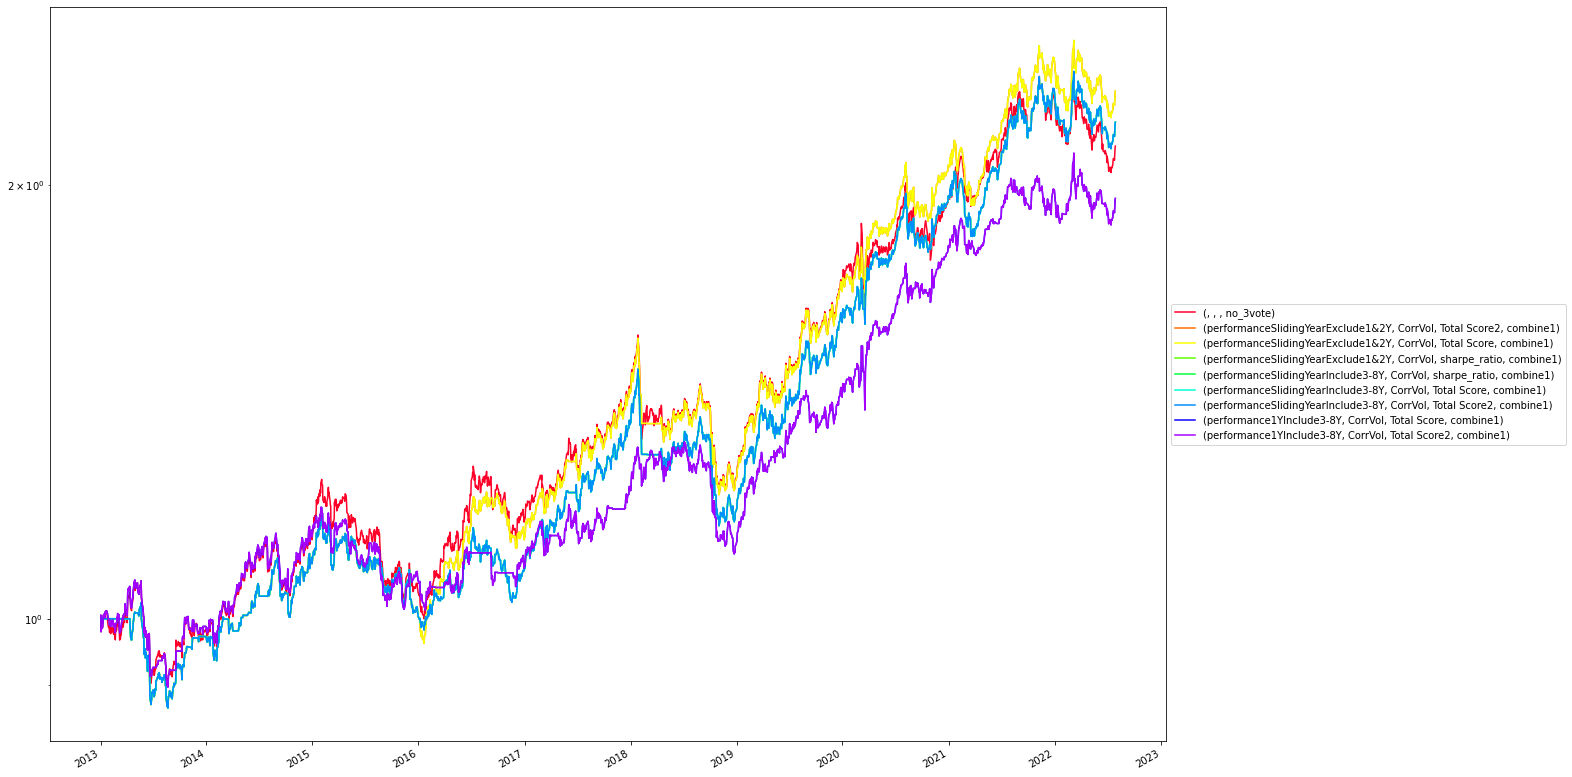

In [253]:
show_ret = pd.concat([base_case_ret, all_ret_df[show_df.index[:10]]], axis=1)
show_ret = show_ret.dropna()
show_cum_ret(show_ret[start:])

# correct 151a

In [30]:
base_folder = './result/2022/cashON_signal/result/yearly_threshold/sliding_withAssetSliding_151a_correcy'
start = '2013'
all_ret = {}
all_met = {}
if True:
    case_folder = base_folder
    for f in os.listdir(case_folder):
        try:
            case_type2 = f.split('_')
            if len(case_type2) > 2:
                case_type2 = [case_type2[0], "_".join(case_type2[1:])]
            # case_type2 = [sliding_case_name] + case_type2
            # if len(case_type2) > 2:
            #     case_type2 = [case_type2[0], "_".join(case_type2[1:])]
            print(case_type2)

            ret = pd.read_csv(os.path.join(case_folder, f, 'final_ret.csv'), index_col=0)
            names = ['case_metrics', 'case_combine']
            ret.columns = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in ret.columns], names=names)
            ret.index = pd.to_datetime(ret.index)
            all_ret[tuple(case_type2)] = ret
            met = pd.read_csv(os.path.join(case_folder, f, 'final_metrics.csv'), index_col=0)
            names = ['case_metrics', 'case_combine']
            met.index = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in met.index], names=names)
            all_met[tuple(case_type2)] = met
        except Exception as e:
            print("Failed for {}".format(f))
            print(e)
    # break
all_ret_df = pd.concat(all_ret.values(), keys=all_ret.keys(), axis=1)

# 13ETFs	v1	sliding1Y	2thresholds	combine2	no_3vote
idx_names = ['sliding_year', 'case_pool', 'case_metrics', 'case_combine']
all_ret_df.columns.names = idx_names

['met(from2013).csv']
Failed for met(from2013).csv
[Errno 2] No such file or directory: './result/2022/cashON_signal/result/yearly_threshold/sliding_withAssetSliding_151a_correcy\\met(from2013).csv\\final_ret.csv'
['performanceSlidingYearInclude3-5Y', 'CorrVol']
['sliding1Y', 'CorrVol']
['sliding2Y', 'CorrVol']
['sliding3Y', 'CorrVol']
['sliding4Y', 'CorrVol']
['sliding5Y', 'CorrVol']


In [31]:
all_met_df = empy_metric(all_ret_df[start:].dropna())
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df[start:].dropna())], axis=1)
# all_met_df_dict[sliding_case_name] = all_met_df

In [20]:
all_met_df.to_csv(os.path.join(base_folder, 'met(from{}).csv'.format(start)))

In [21]:
base_case_name = 'no_3vote'
base_case_ret = all_ret_df.loc[:, all_ret_df.columns.get_level_values('case_combine') == base_case_name].iloc[:, [0]]
base_case_ret.columns = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
# display(base_case_ret)
base_case_met = all_met_df.loc[all_met_df.index.get_level_values('case_combine') == base_case_name, :].iloc[[0], :]
base_case_met.index = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
base_case_met

,,,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,case_metrics,case_combine,,,,,,,,,,,,,,,,
,,,no_3vote,1.606457,0.105315,0.818926,0.133141,-0.205393,-0.05718,0.512749,1.841813,81.892594,105.265742,79.460733,94.282002,3.594241,3.308341,1.0,0.0


In [22]:
sort_by = 'sharpe_ratio'
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
show_df = pd.concat([base_case_met, show_df])
sort_df

total_return  \
sliding_year                      case_pool case_metrics case_combine                 
sliding3Y                         CorrVol   Total Score2 combine1          1.811856   
                                            Total Score  combine1          1.811015   
performanceSlidingYearInclude3-5Y CorrVol   Total Score2 combine1          1.726456   
                                            Total Score  combine1          1.725641   
                                            sharpe_ratio combine1          1.693658   
sliding3Y                         CorrVol   sharpe_ratio combine1          1.642355   
sliding4Y                         CorrVol   sharpe_ratio combine1          1.464127   
                                            Total Score2 combine1          1.466488   
performanceSlidingYearInclude3-5Y CorrVol                no_3vote          1.606457   
sliding5Y                         CorrVol                no_3vote          1.606457   
sliding4Y                         CorrVol                no_3vote          1.606457   
sliding3Y                         CorrVol                no_3vote          1.606457   
sliding2Y                         CorrVol                no_3vote          1.606457   
sliding1Y                         CorrVol                no_3vote          1.606457   
sliding4Y                         CorrVol   Total Score  combine1          1.341478   
sliding5Y                         CorrVol   sharpe_ratio combine1          1.275951   
sliding2Y                         CorrVol   Total Score  combine1          1.250058   
sliding5Y                         CorrVol   Total Score  combine1          1.178050   
                                            Total Score2 combine1          1.178050   
sliding2Y                         CorrVol   sharpe_ratio combine1          1.118630   
                                            Total Score2 combine1          1.063166   
sliding1Y                         CorrVol   Total Score2 combine1          0.902419   
                                            Total Score  combine1          0.902419   
                                            sharpe_ratio combine1          0.646896   

                                                                       annual_return  \
sliding_year                      case_pool case_metrics case_combine                  
sliding3Y                         CorrVol   Total Score2 combine1           0.114113   
                                            Total Score  combine1           0.114078   
performanceSlidingYearInclude3-5Y CorrVol   Total Score2 combine1           0.110527   
                                            Total Score  combine1           0.110492   
                                            sharpe_ratio combine1           0.109123   
sliding3Y                         CorrVol   sharpe_ratio combine1           0.106896   
sliding4Y                         CorrVol   sharpe_ratio combine1           0.098846   
                                            Total Score2 combine1           0.098956   
performanceSlidingYearInclude3-5Y CorrVol                no_3vote           0.105315   
sliding5Y                         CorrVol                no_3vote           0.105315   
sliding4Y                         CorrVol                no_3vote           0.105315   
sliding3Y                         CorrVol                no_3vote           0.105315   
sliding2Y                         CorrVol                no_3vote           0.105315   
sliding1Y                         CorrVol                no_3vote           0.105315   
sliding4Y                         CorrVol   Total Score  combine1           0.092998   
sliding5Y                         CorrVol   sharpe_ratio combine1           0.089760   
sliding2Y                         CorrVol   Total Score  combine1           0.088458   
sliding5Y                         CorrVol   Total Score  combine1           0.084764   
                                            Tota

In [28]:
tmp_ret = {}
case = '151b'

In [32]:
case = '151a'
tmp_ret[case] = all_ret_df.loc[:, [('performanceSlidingYearInclude3-5Y', 'CorrVol', 'Total Score2', 'combine1'), ('performanceSlidingYearInclude3-5Y', 'CorrVol', '', 'no_3vote')]]

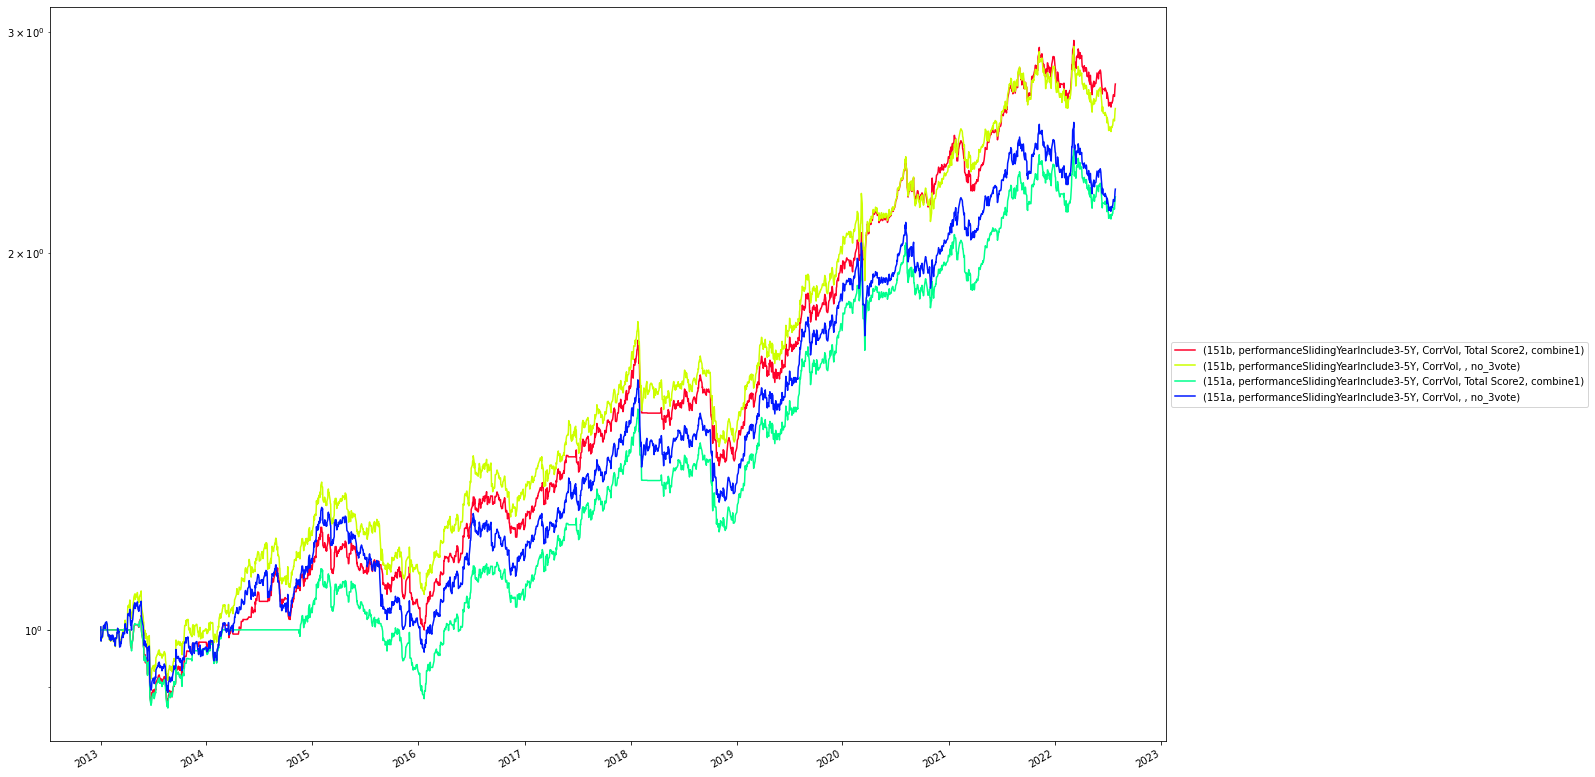

In [35]:
tmp_ret_df = pd.concat(tmp_ret.values(), keys=tmp_ret.keys(), axis=1)
show_ret = tmp_ret_df.dropna()
show_cum_ret(tmp_ret_df[start:])